<a href="https://colab.research.google.com/github/CarlosSotero/NFL_Stats_Players/blob/main/NFL_Moderna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Bibliotecas nescessárias**

In [440]:
import kagglehub
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

## **Download dos datasets**

In [441]:
# Download latest version
path = kagglehub.dataset_download("philiphyde1/nfl-stats-1999-2022")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'nfl-stats-1999-2022' dataset.
Path to dataset files: /kaggle/input/nfl-stats-1999-2022


In [442]:
# Mostra os arquivos que vieram no caminho do kagglehub
print(os.listdir(path))


['yearly_player_stats_defense.csv', 'yearly_player_stats_offense.csv', 'yearly_team_stats_offense.csv', 'weekly_player_stats_offense.csv', 'yearly_team_stats_defense.csv', 'weekly_player_stats_defense.csv', 'weekly_team_stats_defense.csv', 'weekly_team_stats_offense.csv']


In [443]:
# Carregar os datasets anuais por jogador (ofensivo e defensivo)
offense_path = path + "/yearly_player_stats_offense.csv"
defense_path = path + "/yearly_player_stats_defense.csv"
df_offense = pd.read_csv(offense_path)
df_defense = pd.read_csv(defense_path)

# Colunas do df de ataque selecionadas
offense_cols = [
    'player_id', 'player_name', 'position', 'team', 'season', 'age', 'games_played_season',
    'height', 'weight', 'college', 'draft_year', 'draft_round', 'draft_pick', 'years_exp',
    'pass_attempts', 'complete_pass', 'passing_yards', 'pass_touchdown', 'interception',
    'passer_rating', 'comp_pct', 'ypa',
    'rush_attempts', 'rushing_yards', 'rush_touchdown', 'fumble', 'fumble_lost', 'ypc',
    'targets', 'receptions', 'receiving_yards', 'receiving_touchdown', 'yards_after_catch', 'yptarget', 'ypr',
    'total_yards', 'total_tds', 'fantasy_points_ppr', 'fantasy_points_standard',
    'season_ypg', 'season_yptouch', 'season_average_ppr_ppg', 'offense_snaps', 'offense_pct'
]

# DF de Ataque com as colunas selecionadas
df_offense_reduzido = df_offense[offense_cols]
print("Shape do DF Ofensivo reduzido:", df_offense_reduzido.shape)


# Colunas do df de defesa selecionadas
defense_cols = [
    'player_id', 'player_name', 'position', 'team', 'season', 'age', 'games_played_season',
    'height', 'weight', 'college', 'draft_year', 'draft_round', 'draft_pick', 'seasons_played',
    'solo_tackle', 'assist_tackle', 'tackle_with_assist', 'sack', 'qb_hit',
    'interception', 'fumble_forced', 'safety', 'def_touchdown',
    'defense_snaps', 'defense_pct', 'fantasy_points_ppr', 'fantasy_points_standard'
]

# DF de Defesa com as colunas selecionadas
df_defense_reduzido = df_defense[defense_cols]
print("Shape do DF Defensivo reduzido:", df_defense_reduzido.shape)


Shape do DF Ofensivo reduzido: (7133, 44)
Shape do DF Defensivo reduzido: (16148, 27)


##**LImpeza dos Dados**

In [444]:
print("🟦 OFENSIVO -----------------------")
print(df_offense_reduzido.info())
print("\n")
print("🟥 DEFENSIVO ----------------------")
print(df_defense_reduzido.info())

🟦 OFENSIVO -----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7133 entries, 0 to 7132
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   player_id                7133 non-null   object 
 1   player_name              7133 non-null   object 
 2   position                 7133 non-null   object 
 3   team                     7133 non-null   object 
 4   season                   7133 non-null   int64  
 5   age                      7133 non-null   float64
 6   games_played_season      7133 non-null   int64  
 7   height                   7133 non-null   float64
 8   weight                   7133 non-null   float64
 9   college                  7133 non-null   object 
 10  draft_year               7133 non-null   float64
 11  draft_round              6043 non-null   float64
 12  draft_pick               6043 non-null   float64
 13  years_exp                7115 non-null   fl

### **Ataque**

In [445]:
# Criando uma cópia do DF de ataque
df_ataque_limpo = df_offense_reduzido.copy()

# Loop para preencher os valores ausentes
for col in df_ataque_limpo.columns:
  if df_ataque_limpo[col].dtype == 'object':
    df_ataque_limpo[col].fillna('Desconhecido', inplace=True)
  else:
    df_ataque_limpo[col].fillna(0, inplace=True)

# Substituindo o 0 por 'Desconhecido' na coluna 'college'
if 'college' in df_ataque_limpo.columns:
  df_ataque_limpo['college'] = df_ataque_limpo['college'].replace(['0', 0], 'Desconhecido')


# Alterando o tipo das colunas de float para int
for col in ['draft_year', 'draft_round', 'draft_pick', 'years_exp', 'age']:
  if col in df_ataque_limpo.columns:
    df_ataque_limpo[col] = df_ataque_limpo[col].astype(int, errors='ignore')

print("Ataque limpo:", df_ataque_limpo.shape)
print("Nulos restantes:", df_ataque_limpo.isnull().sum().sum())

Ataque limpo: (7133, 44)
Nulos restantes: 0


/tmp/ipython-input-207400779.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ataque_limpo[col].fillna('Desconhecido', inplace=True)
/tmp/ipython-input-207400779.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [446]:
print('Amostra de 10 jogadores aleatórios do ataque:')
df_ataque_limpo.sample(10)

Amostra de 10 jogadores aleatórios do ataque:


player_id          player_name position team  season  age  \
4574  00-0035657        Damien Harris       RB   NE    2020   23   
2628  00-0032139           Ben Koyack       TE  JAX    2017   24   
2576  00-0031549       Nelson Agholor       WR  PHI    2017   24   
2715  00-0033077         Dak Prescott       QB  DAL    2017   24   
1013  00-0027696         Jimmy Graham       TE   NO    2014   27   
128   00-0025460         Jacoby Jones       WR  BAL    2012   28   
5660  00-0035406  Lil'Jordan Humphrey       WR   NE    2022   24   
6710  00-0034418       Cedrick Wilson       WR   NO    2024   28   
5037  00-0034521         Allen Lazard       WR   GB    2021   25   
3976  00-0035259         Trevon Wesco       TE  NYJ    2019   23   

      games_played_season  height  weight            college  ...    ypr  \
4574                    9    71.0   213.0            Alabama  ...  10.40   
2628                    6    77.0   258.0         Notre Dame  ...   7.60   
2576                   16    72.0   200.0                USC  ...  12.39   
2715                   16    74.0   238.0  Mississippi State  ...   0.00   
1013                   15    79.0   265.0              Miami  ...  10.46   
128                     3    76.0   215.0               Lane  ...  34.75   
5660                    2    76.0   225.0              Texas  ...   9.00   
6710                   10    74.0   197.0        Boise State  ...  10.55   
5037                   13    77.0   227.0         Iowa State  ...  12.64   
3976                    3    75.0   267.0      West Virginia  ...  23.50   

      total_yards  total_tds  fantasy_points_ppr  fantasy_points_standard  \
4574        643.0        2.0               79.30                    74.30   
2628         38.0        0.0                8.80                     3.80   
2576        775.0       16.0              183.50                   121.50   
2715       3681.0       28.0              301.66                   301.66   
1013        889.0       20.0              221.90                   136.90   
128         139.0        4.0               29.90                    25.90   
5660          9.0        0.0                1.90                     0.90   
6710        232.0        3.0               51.94                    31.94   
5037        525.0       14.0              133.50                    94.50   
3976         49.0        0.0                6.90                     4.90   

      season_ypg  season_yptouch  season_average_ppr_ppg  offense_snaps  \
4574        7.94            5.14                    8.81          228.0   
2628        1.06            7.63                    1.47          152.0   
2576        3.03           12.29                   11.47          811.0   
2715       14.38            6.89                   18.85         1050.0   
1013        3.95           10.45                   14.79          743.0   
128        15.44           34.83                    9.97           90.0   
5660        2.25            9.00                    0.95           85.0   
6710        2.32           11.05                    5.19          307.0   
5037        3.11           12.50                   10.27          621.0   
3976        5.44           16.33                    2.30           63.0   

      offense_pct  
4574     0.407871  
2628     0.342342  
2576     0.717065  
2715     0.985915  
1013     0.687327  
128      0.401786  
5660     0.685484  
6710     0.470138  
5037     0.724621  
3976     0.328125  

[10 rows x 44 columns]

###**Defesa**

In [447]:
# Criando uma cópia do DF de ataque
df_defesa_limpo = df_defense_reduzido.copy()

# Remove linhas que estão sem o nome e a posição dos jogadores
df_defesa_limpo = df_defesa_limpo.dropna(subset=['player_name', 'position'])

# Loop para preencher os valores ausentes
for col in df_defesa_limpo.columns:
  if df_defesa_limpo[col].dtype == 'object':
    df_defesa_limpo[col].fillna('Desconhecido', inplace=True)
  else:
    df_defesa_limpo[col].fillna(0, inplace=True)

# Substituindo o 0 por 'Desconhecido' na coluna 'college'
if 'college' in df_defesa_limpo.columns:
  df_defesa_limpo['college'] = df_defesa_limpo['college'].replace(['0', 0], 'Desconhecido')

# Alterando o tipo das colunas de float para int
for col in ['draft_year', 'draft_round', 'draft_pick', 'age']:
    if col in df_defesa_limpo.columns:
        df_defesa_limpo[col] = df_defesa_limpo[col].astype(int, errors='ignore')

print("Defensivo limpo:", df_defesa_limpo.shape)
print("Nulos restantes:", df_defesa_limpo.isnull().sum().sum())

Defensivo limpo: (12332, 27)
Nulos restantes: 0


/tmp/ipython-input-2341386716.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_defesa_limpo[col].fillna('Desconhecido', inplace=True)
/tmp/ipython-input-2341386716.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

In [448]:
print('Amostra de 10 jogadores aleatórios da defesa:')
df_defesa_limpo.sample(10)

Amostra de 10 jogadores aleatórios da defesa:


player_id      player_name position team  season  age  \
2850   00-0027647   Devin McCourty        S   NE    2014   27   
9717   00-0035318      Ken Webster       CB  MIA    2019   23   
8018   00-0032402  Hassan Ridgeway       DT  IND    2018   24   
16030  00-0039366    Tarheeb Still       CB  LAC    2024   22   
14390  00-0036500  Jamien Sherwood       LB  NYJ    2023   23   
15318  00-0035279  Charles Omenihu       DE   KC    2024   27   
9337   00-0033577       Nate Gerry       LB  PHI    2019   24   
3330   00-0030196       Jeff Heath        S  DAL    2014   23   
10636  00-0034646   Brandon Powell       WR  ATL    2020   25   
3563   00-0031298      Jimmie Ward        S   SF    2014   23   

       games_played_season  height  weight               college  ...  sack  \
2850                  19.0    70.0   195.0               Rutgers  ...   0.0   
9717                   7.0    71.0   202.0           Mississippi  ...   0.0   
8018                   5.0    75.0   305.0                 Texas  ...   3.0   
16030                 15.0    73.0   196.0              Maryland  ...   3.0   
14390                 13.0    74.0   216.0                Auburn  ...   0.0   
15318                  9.0    77.0   280.0                 Texas  ...   6.0   
9337                  16.0    74.0   218.0              Nebraska  ...  11.0   
3330                   8.0    73.0   212.0  Saginaw Valley State  ...   0.0   
10636                  1.0    68.0   185.0               Florida  ...   0.0   
3563                   8.0    71.0   193.0     Northern Illinois  ...   0.0   

       qb_hit  interception  fumble_forced  safety  def_touchdown  \
2850      7.0           6.0              2     0.0            0.0   
9717      1.0           0.0              0     0.0            0.0   
8018      4.0           0.0              0     0.0            0.0   
16030     5.0           9.0              0     0.0            2.0   
14390     0.0           0.0              3     0.0            0.0   
15318     6.0           0.0              8     0.0            0.0   
9337     20.0           4.0              2     0.0            2.0   
3330      0.0           0.0              0     0.0            0.0   
10636     0.0           0.0              0     0.0            0.0   
3563      0.0           0.0              0     0.0            0.0   

       defense_snaps  defense_pct  fantasy_points_ppr  fantasy_points_standard  
2850          1177.0     0.923137                   0                        0  
9717           222.0     0.477419                   0                        0  
8018            86.0     0.247126                   0                        0  
16030          824.0     0.833165                   0                        0  
14390          175.0     0.200458                   0                        0  
15318          347.0     0.564228                   0                        0  
9337             0.0     0.000000                   0                        0  
3330           101.0     0.191651                   0                        0  
10636            0.0     0.000000                   0                        0  
3563           262.0     0.508738                   0                        0  

[10 rows x 27 columns]

### **Análises dos dados**

In [449]:
# Verificando a quantidade por de valores unicos por temporada
print(df_ataque_limpo['season'].value_counts().sort_index())
print(df_defesa_limpo['season'].value_counts().sort_index())


season
2012    411
2013    421
2014    480
2015    455
2016    515
2017    545
2018    593
2019    618
2020    650
2021    638
2022    626
2023    604
2024    577
Name: count, dtype: int64
season
2012     865
2013     877
2014     912
2015     912
2016     925
2017     927
2018     942
2019     968
2020     995
2021    1050
2022     984
2023     983
2024     992
Name: count, dtype: int64


In [450]:
# Conferindo as posições do Ataque e Defesa
print('Posições ataque:', df_ataque_limpo['position'].unique())

print('Posições defesa:', df_defesa_limpo['position'].unique())

Posições ataque: ['QB' 'WR' 'TE' 'P' 'RB' 'FS' 'FB' 'CB' 'LS' 'ILB' 'DT' 'DE' 'NT' 'SS' 'K'
 'T' 'OLB' 'MLB']
Posições defesa: ['ILB' 'CB' 'FS' 'OLB' 'DE' 'MLB' 'NT' 'DT' 'SS' 'LB' 'S' 'WR' 'RB' 'TE'
 'DB' 'FB' 'T' 'C' 'G']


In [451]:
# Diagnóstico: quantos jogadores estão fora de posição
ataque_incorreto = df_ataque_limpo.query("offense_snaps == 0")
defesa_incorreta = df_defesa_limpo.query("defense_snaps == 0")

print("Jogadores de defesa no dataset de ataque:")
print(ataque_incorreto[['player_name', 'position', 'offense_snaps']])

print("\nJogadores de ataque no dataset de defesa:")
print(defesa_incorreta[['player_name', 'position', 'defense_snaps']])

# Verifique o tamanho
n_ataque = len(df_ataque_limpo)
n_defesa = len(df_defesa_limpo)
pct_ataque_incorreto = len(ataque_incorreto) / n_ataque * 100
pct_defesa_incorreta = len(defesa_incorreta) / n_defesa * 100

print(f"\n{pct_ataque_incorreto:.2f}% dos registros de ataque são jogadores de defesa.")
print(f"{pct_defesa_incorreta:.2f}% dos registros de defesa são jogadores de ataque.")


Jogadores de defesa no dataset de ataque:
               player_name position  offense_snaps
14           Shane Lechler        P            0.0
68         Dustin Colquitt        P            0.0
104               Sam Koch        P            0.0
105               Sam Koch        P            0.0
120            Eric Weddle       FS            0.0
...                    ...      ...            ...
6886         Divine Deablo      MLB            0.0
6963           Dane Belton       SS            0.0
6972  Carrington Valentine       CB            0.0
7103           Jaden Hicks       SS            0.0
7104       Kamren Kinchens       FS            0.0

[179 rows x 3 columns]

Jogadores de ataque no dataset de defesa:
                player_name position  defense_snaps
16             Takeo Spikes      ILB            0.0
38          Richard Seymour       DT            0.0
40             Andre Carter       DE            0.0
69           Quentin Jammer       CB            0.0
72           Quinti

In [452]:
# Contabilizando os jogadores de ataque que estão no df de defesa
defesa_incorreta['position'].value_counts()

position
WR     308
CB     234
DE     167
DT     142
LB     131
S      104
RB      94
TE      58
OLB     40
ILB     24
FS      23
MLB     21
SS      21
NT      11
T        7
FB       3
DB       2
G        2
C        1
Name: count, dtype: int64

In [453]:
# Eliminando os jogadores com 0 snaps dos dfs
df_ataque_limpo = df_ataque_limpo.query("offense_snaps > 0")
df_defesa_limpo = df_defesa_limpo.query("defense_snaps > 0")


###**Feature Engineering**

####**Ataque**

In [454]:
#  Total de Touchdowns
df_ataque_limpo['total_touchdown'] = df_ataque_limpo['pass_touchdown'] + df_ataque_limpo['rush_touchdown']


# Jardas por tentativa de passe (protege contra divisão por zero)
df_ataque_limpo['yards_per_pass_attempt'] = np.where(
    df_ataque_limpo['pass_attempts'] > 0,
    df_ataque_limpo['passing_yards'] / df_ataque_limpo['pass_attempts'],
    0
)

# Jardas por tentativa de corrida
df_ataque_limpo['yards_per_carry'] = np.where(
    df_ataque_limpo['rush_attempts'] > 0,
    df_ataque_limpo['rushing_yards'] / df_ataque_limpo['rush_attempts'],
    0
)

# Jardas por recepção
df_ataque_limpo['yards_per_reception'] = np.where(
    df_ataque_limpo['receptions'] > 0,
    df_ataque_limpo['receiving_yards'] / df_ataque_limpo['receptions'],
    0
)

# Taxa de recepção
df_ataque_limpo['catch_rate'] = np.where(
    df_ataque_limpo['targets'] > 0,
    df_ataque_limpo['receptions'] / df_ataque_limpo['targets'],
    0
)

# Total de "touches" (corridas + recepções)
df_ataque_limpo['touches'] = df_ataque_limpo['rush_attempts'] + df_ataque_limpo['receptions']

# Jardas por toque
df_ataque_limpo['yards_per_touch'] = np.where(
    df_ataque_limpo['touches'] > 0,
    df_ataque_limpo['total_yards'] / df_ataque_limpo['touches'],
    0
)


In [455]:
# 5 jogadores aleatorios de ataque
df_ataque_limpo.sample(5)

player_id        player_name position team  season  age  \
5987  00-0031237  Teddy Bridgewater       QB  DET    2023   30   
3865  00-0034370   DaeSean Hamilton       WR  DEN    2019   24   
4032  00-0035703       Miles Boykin       WR  BAL    2019   22   
6758  00-0035264    Jarrett Stidham       QB  DEN    2024   28   
388   00-0029614       Chris Givens       WR   LA    2012   22   

      games_played_season  height  weight      college  ...  \
5987                    1    74.0   210.0   Louisville  ...   
3865                   12    73.0   206.0   Penn State  ...   
4032                   12    76.0   222.0   Notre Dame  ...   
6758                    2    75.0   215.0       Auburn  ...   
388                    15    72.0   203.0  Wake Forest  ...   

      season_average_ppr_ppg  offense_snaps  offense_pct  total_touchdown  \
5987                   -0.20            3.0     0.050000              0.0   
3865                    5.31          508.0     0.672848              1.0   
4032                    4.23          341.0     0.397436              3.0   
6758                    0.25           11.0     0.077465              0.0   
388                     8.60          615.0     0.640625              3.0   

      yards_per_pass_attempt  yards_per_carry  yards_per_reception  \
5987                     0.0            -1.00             0.000000   
3865                     0.0             0.00            10.607143   
4032                     0.0             0.00            15.230769   
6758                     0.0             1.25             0.000000   
388                      0.0             4.00            16.619048   

      catch_rate  touches  yards_per_touch  
5987    0.000000      2.0        -1.000000  
3865    0.538462     28.0        10.607143  
4032    0.590909     13.0        15.230769  
6758    0.000000      4.0         1.250000  
388     0.531646     45.0        15.777778  

[5 rows x 51 columns]

###**Defesa**

In [456]:
# Colunas no df de defesa
df_defesa_limpo.columns

Index(['player_id', 'player_name', 'position', 'team', 'season', 'age',
       'games_played_season', 'height', 'weight', 'college', 'draft_year',
       'draft_round', 'draft_pick', 'seasons_played', 'solo_tackle',
       'assist_tackle', 'tackle_with_assist', 'sack', 'qb_hit', 'interception',
       'fumble_forced', 'safety', 'def_touchdown', 'defense_snaps',
       'defense_pct', 'fantasy_points_ppr', 'fantasy_points_standard'],
      dtype='object')

In [457]:
# Tackle totais
df_defesa_limpo['tackles_total'] = df_defesa_limpo['solo_tackle'] + df_defesa_limpo['assist_tackle']

# Taxa de sacks por snap
df_defesa_limpo['sack_rate'] = df_defesa_limpo['sack'] / df_defesa_limpo['defense_snaps']

# Tackles por jogo
df_defesa_limpo['tackles_per_game'] = df_defesa_limpo['tackles_total'] / df_defesa_limpo['games_played_season']

# Jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD)
df_defesa_limpo['impact_plays'] = (
    df_defesa_limpo['sack'] +
    df_defesa_limpo['interception'] +
    df_defesa_limpo['fumble_forced'] +
    df_defesa_limpo['safety'] +
    df_defesa_limpo['def_touchdown']
)


In [458]:
# 5 jogadores aleatorios de defesa
df_defesa_limpo.sample(5)

player_id      player_name position team  season  age  \
12233  00-0036502    Jason Pinnock        S  NYJ    2021   22   
11146  00-0029530    Justin Bethel       CB   NE    2021   31   
14379  00-0036416  Kristian Fulton       CB  TEN    2023   25   
12685  00-0033084   Kendall Fuller       CB  WAS    2022   27   
12047  00-0035903      Joe Gaziano       DT  LAC    2021   25   

       games_played_season  height  weight        college  ...  safety  \
12233                  5.0    72.0   200.0     Pittsburgh  ...     0.0   
11146                  5.0    72.0   295.0   Presbyterian  ...     0.0   
14379                 11.0    71.0   197.0            LSU  ...     0.0   
12685                 16.0    71.0   198.0  Virginia Tech  ...     0.0   
12047                  9.0    76.0   275.0   Northwestern  ...     0.0   

       def_touchdown  defense_snaps  defense_pct  fantasy_points_ppr  \
12233            0.0          194.0     0.544944                   0   
11146            0.0           31.0     0.080103                   0   
14379            0.0          645.0     0.870445                   0   
12685            4.0          979.0     0.986895                   0   
12047            0.0          168.0     0.269663                   0   

       fantasy_points_standard  tackles_total  sack_rate  tackles_per_game  \
12233                        0           13.0        0.0          2.600000   
11146                        0            5.0        0.0          1.000000   
14379                        0           48.0        0.0          4.363636   
12685                        0           53.0        0.0          3.312500   
12047                        0           16.0        0.0          1.777778   

       impact_plays  
12233           4.0  
11146           1.0  
14379           0.0  
12685          10.0  
12047           0.0  

[5 rows x 31 columns]

##**Análise Exploratória**

###**Ataque**

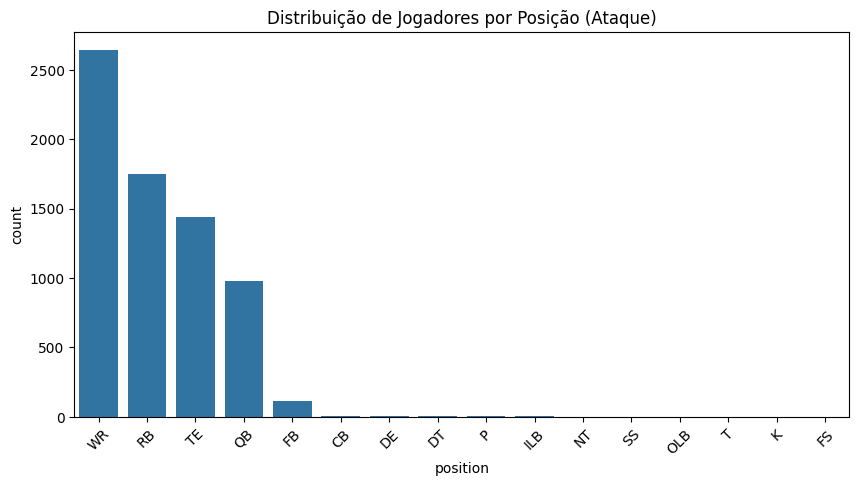

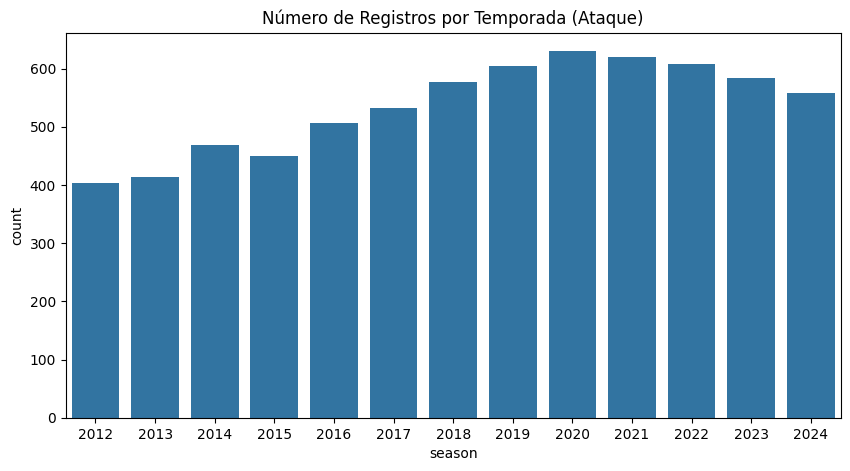

In [459]:
# Gráfico para verificar a distribuição dos jogadores por posição
plt.figure(figsize=(10,5))
sns.countplot(data=df_ataque_limpo, x='position', order=df_ataque_limpo['position'].value_counts().index)
plt.title('Distribuição de Jogadores por Posição (Ataque)')
plt.xticks(rotation=45)
plt.show()

# Número de registros por temporada
plt.figure(figsize=(10,5))
sns.countplot(data=df_ataque_limpo, x='season')
plt.title('Número de Registros por Temporada (Ataque)')
plt.show()


In [460]:
# Estatísticas do ataque
df_ataque_limpo.describe()[['passing_yards', 'rushing_yards', 'receiving_yards', 'total_touchdown', 'fantasy_points_ppr']]

passing_yards  rushing_yards  receiving_yards  total_touchdown  \
count    6954.000000    6954.000000      6954.000000      6954.000000   
mean      234.644953     102.130860       221.098504         3.616192   
std       842.062334     239.783109       306.600714         6.347103   
min        -7.000000     -31.000000       -15.000000         0.000000   
25%         0.000000       0.000000        11.000000         0.000000   
50%         0.000000       2.000000        85.000000         1.000000   
75%         0.000000      61.000000       310.000000         4.000000   
max      5477.000000    2027.000000      1964.000000        56.000000   

       fantasy_points_ppr  
count         6954.000000  
mean            78.678392  
std             89.907939  
min             -4.720000  
25%             11.200000  
50%             41.400000  
75%            119.700000  
max            513.980000

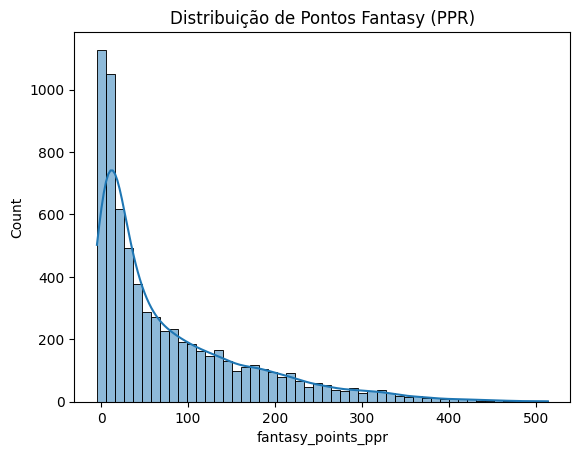

In [461]:
# Distribuição de Pontos do Fantasy
sns.histplot(df_ataque_limpo['fantasy_points_ppr'], bins=50, kde=True)
plt.title('Distribuição de Pontos Fantasy (PPR)')
plt.show()


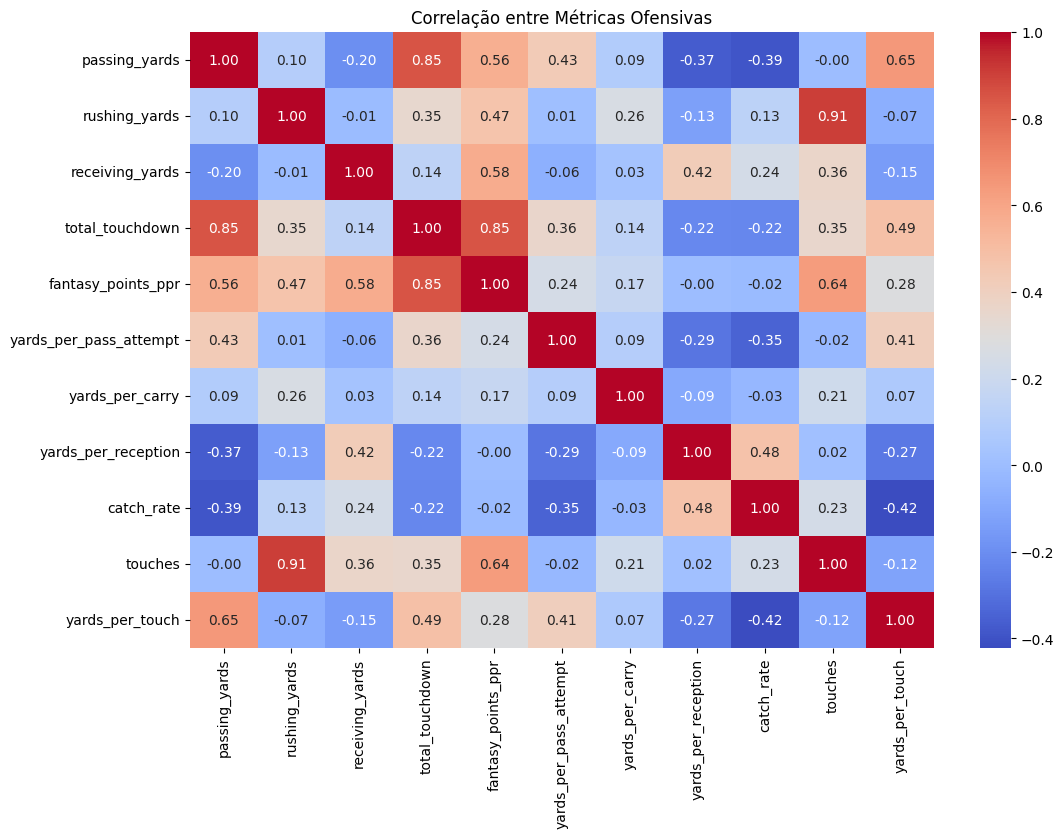

In [462]:
# Correlação entre variáveis
corr_cols = ['passing_yards', 'rushing_yards', 'receiving_yards', 'total_touchdown', 'fantasy_points_ppr', 'yards_per_pass_attempt',
             'yards_per_carry',  'yards_per_reception', 'catch_rate', 'touches', 'yards_per_touch']
plt.figure(figsize=(12, 8))
sns.heatmap(df_ataque_limpo[corr_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação entre Métricas Ofensivas')
plt.show()


#### **QBs**

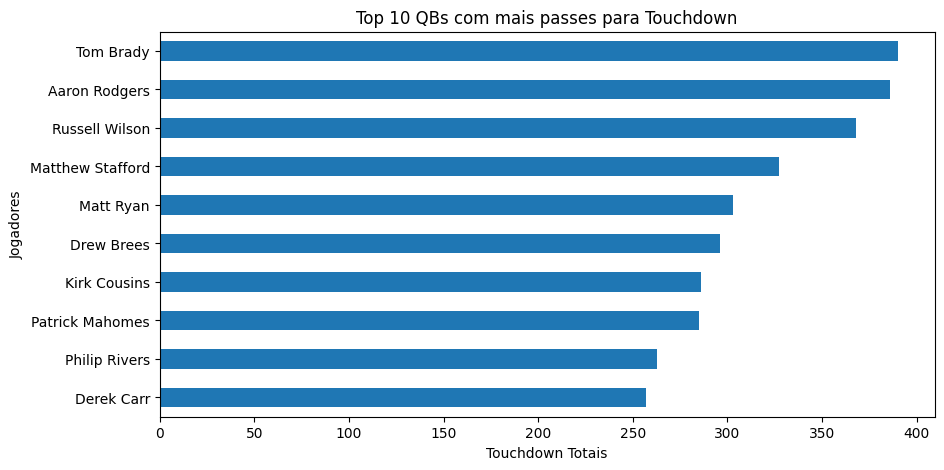

In [463]:
# Top QBs com mais passes para touchdown
qbs= df_ataque_limpo[df_ataque_limpo['position'] == 'QB']
top_qbs_touch = qbs.groupby('player_name')['pass_touchdown'].sum().nlargest(10)
top_qbs_touch.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais passes para Touchdown')
plt.ylabel('Jogadores')
plt.xlabel('Touchdown Totais')
plt.show()


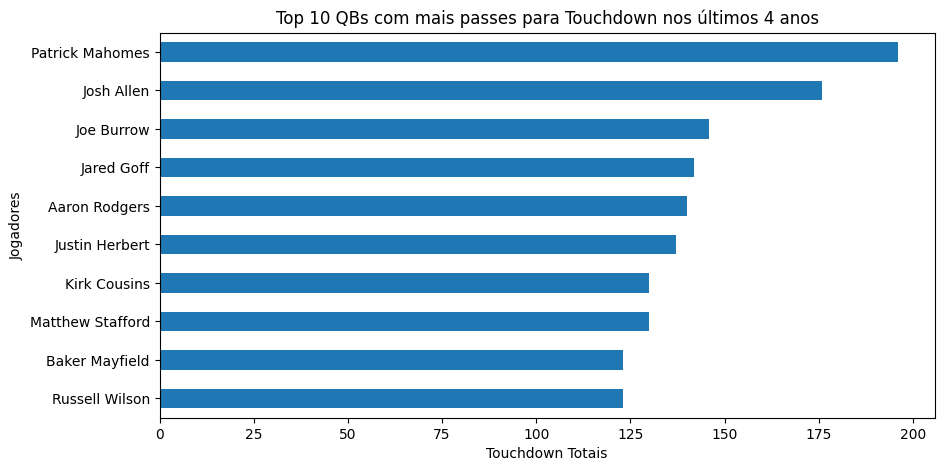

In [464]:
# Top QBs com mais passes para touchdown nos últimos 4 anos
qbs_recentes = df_ataque_limpo[(df_ataque_limpo['position'] == 'QB') & (df_ataque_limpo['season'] >= 2020)]
top_qbs_touch_recente = qbs_recentes.groupby('player_name')['pass_touchdown'].sum().nlargest(10)
top_qbs_touch_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais passes para Touchdown nos últimos 4 anos')
plt.xlabel('Touchdown Totais')
plt.ylabel('Jogadores')
plt.show()

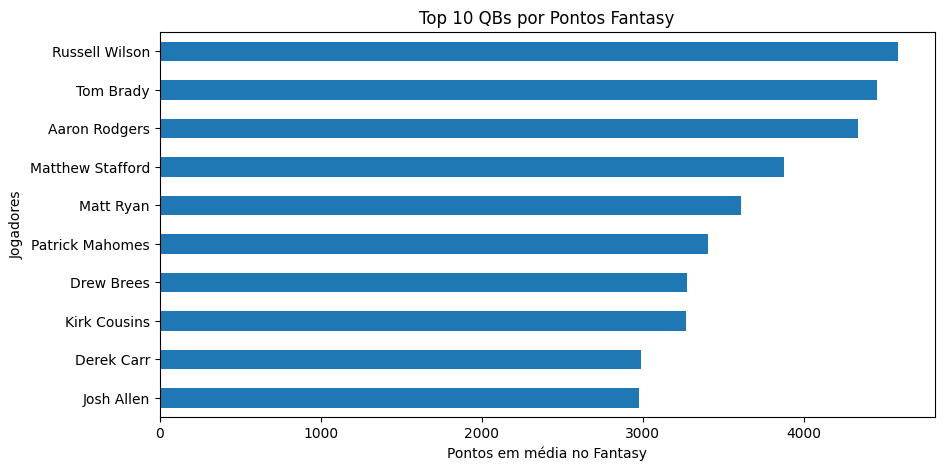

In [465]:
# Top QBs em pontos fantasy
top_qbs_fantasy = qbs.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_qbs_fantasy.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs por Pontos Fantasy')
plt.xlabel('Pontos em média no Fantasy')
plt.ylabel('Jogadores')
plt.show()


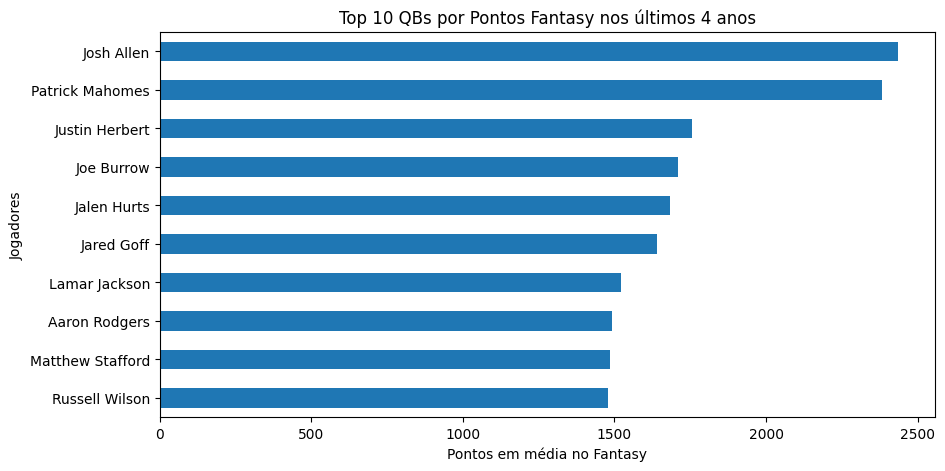

In [466]:
# Top 10 QBs por Pontos Fantasy nos últimos 4 anos
top_qbs_fantasy_recentes = qbs_recentes.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_qbs_fantasy_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs por Pontos Fantasy nos últimos 4 anos')
plt.xlabel('Pontos em média no Fantasy')
plt.ylabel('Jogadores')
plt.show()

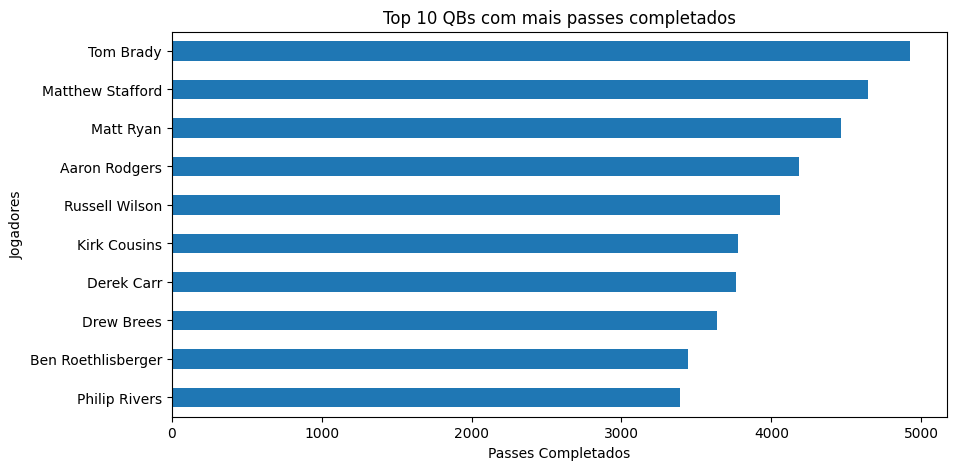

In [467]:
# Top QBs com mais passes completados
top_qbs_compl = qbs.groupby('player_name')['complete_pass'].sum().nlargest(10)
top_qbs_compl.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais passes completados')
plt.xlabel('Passes Completados')
plt.ylabel('Jogadores')
plt.show()

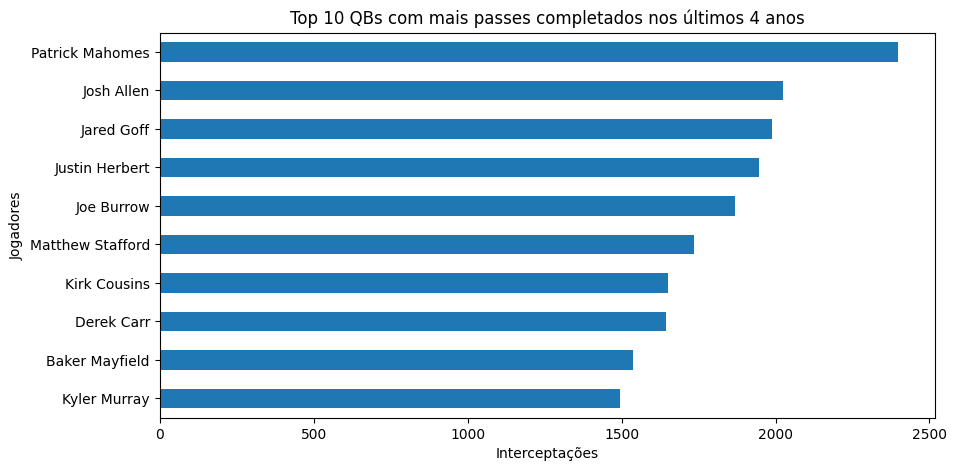

In [468]:
# Top QBs com mais passes completados os últimos 4 anos
top_qbs_compl_recentes = qbs_recentes.groupby('player_name')['complete_pass'].sum().nlargest(10)
top_qbs_compl_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais passes completados nos últimos 4 anos')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

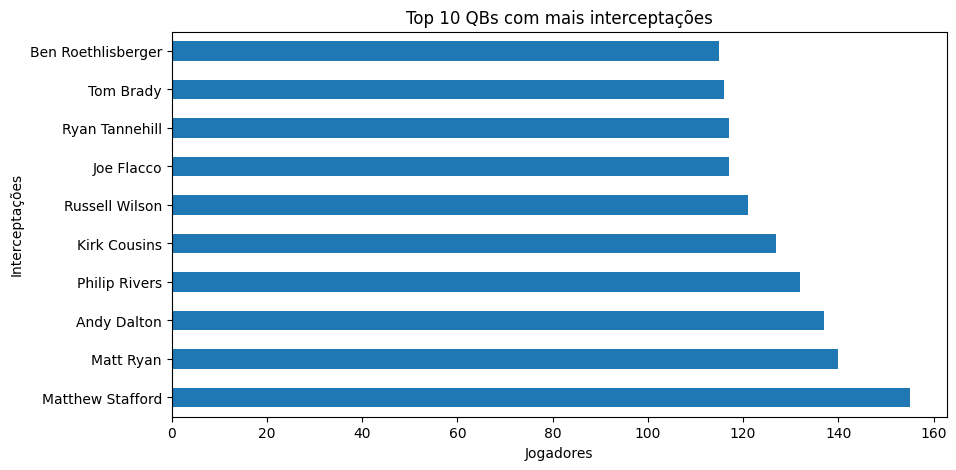

In [469]:
# Top QBs com mais interceptações
top_qbs_int = qbs.groupby('player_name')['interception'].sum().nlargest(10)
top_qbs_int.plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais interceptações')
plt.ylabel('Interceptações')
plt.xlabel('Jogadores')
plt.show()

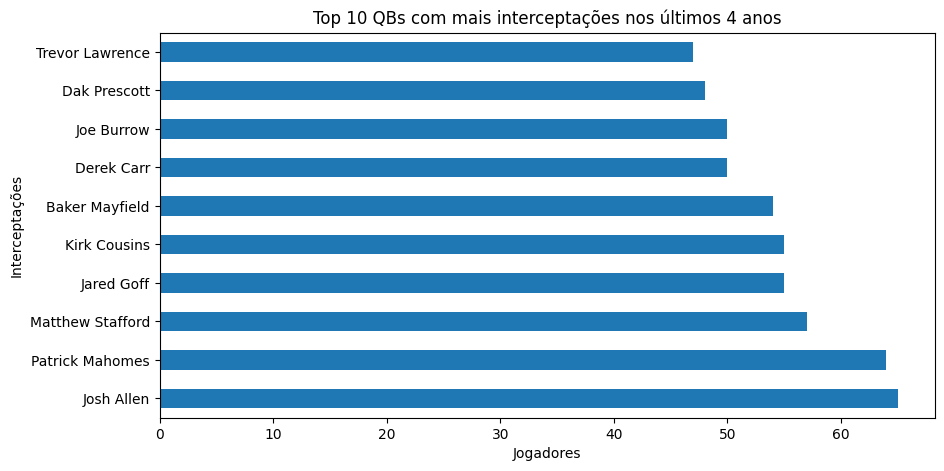

In [470]:
# Top QBs com mais interceptações nos últimos 4 anos
top_qbs_int = qbs_recentes.groupby('player_name')['interception'].sum().nlargest(10)
top_qbs_int.plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais interceptações nos últimos 4 anos')
plt.ylabel('Interceptações')
plt.xlabel('Jogadores')
plt.show()

####**WR**

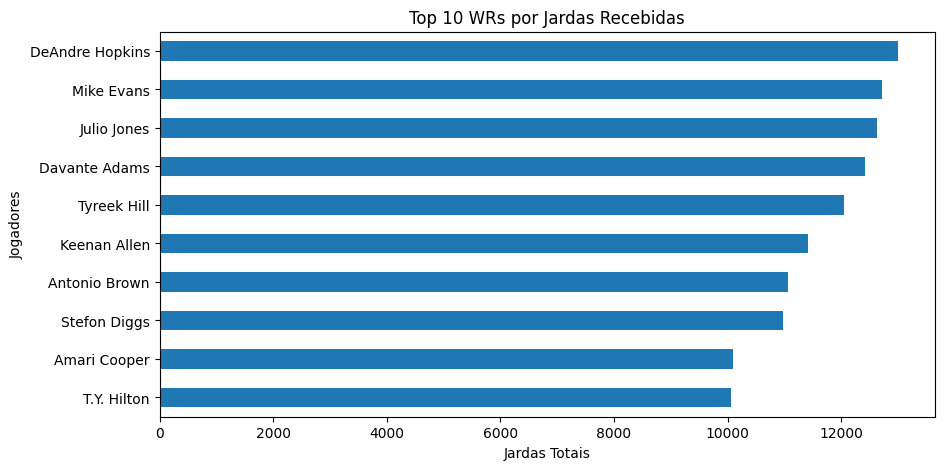

In [471]:
# Top WRs em jardas recebidas
wrs = df_ataque_limpo[df_ataque_limpo['position'] == 'WR']
top_wrs = wrs.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_wrs.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs por Jardas Recebidas')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()


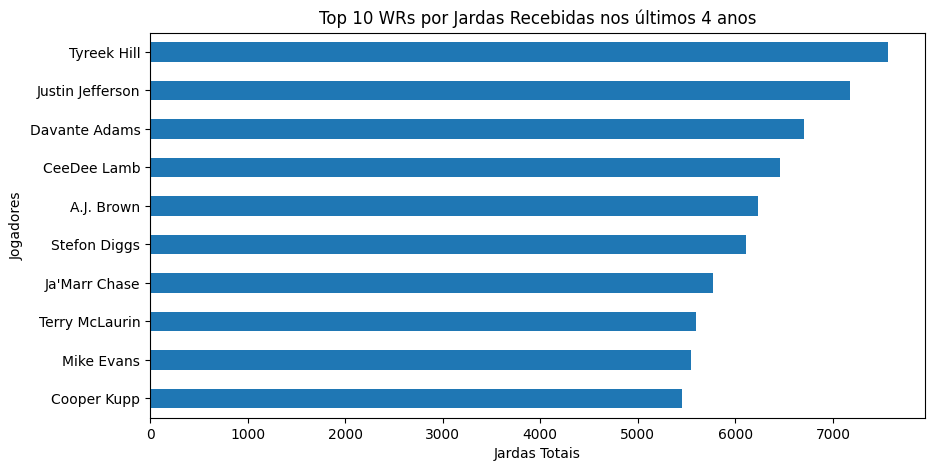

In [472]:
# Top WRs em jardas recebidas nos últimos 4 anos
top_wrs_recentes = df_ataque_limpo[(df_ataque_limpo['position'] == 'WR') & (df_ataque_limpo['season'] >= 2020)]
top_wrs_jardas_recentes = top_wrs_recentes.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_wrs_jardas_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs por Jardas Recebidas nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()


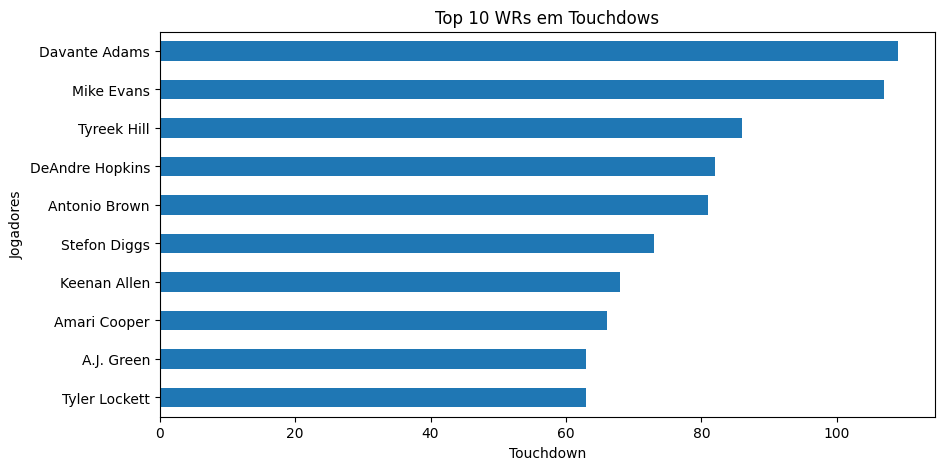

In [473]:
# Top WRs em Tochdowns
top_wrs_touch = wrs.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_wrs_touch.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Touchdows')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

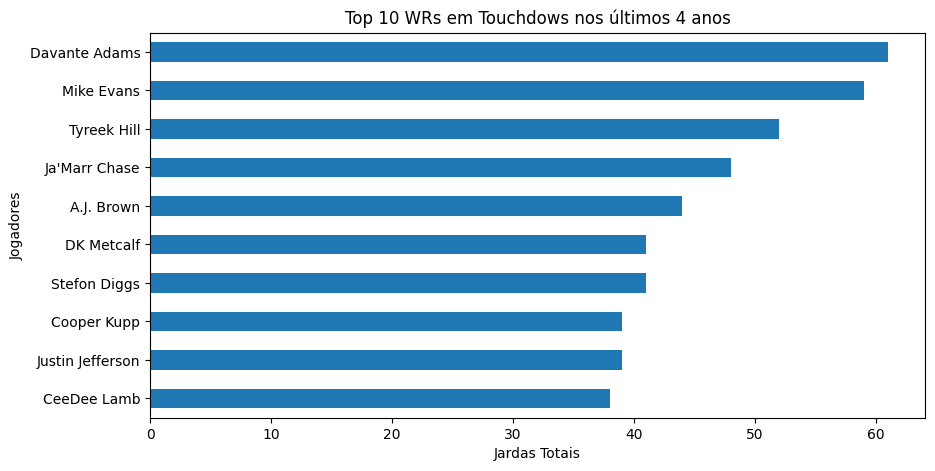

In [474]:
# Top WRs em jardas recebidas nos últimos 4 anos
top_wrs_touch_recentes = top_wrs_recentes.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_wrs_touch_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Touchdows nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()


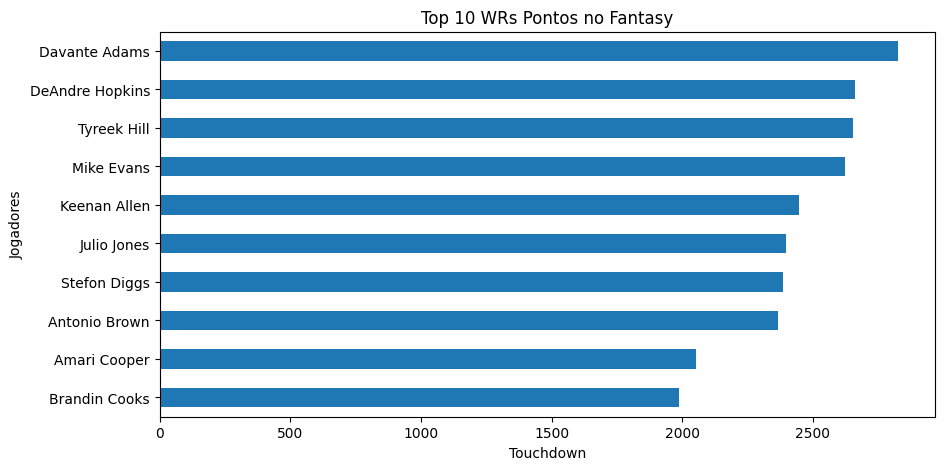

In [475]:
# Top WRs Pontos no Fantasy
top_wrs_fantasy = wrs.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_wrs_fantasy.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs Pontos no Fantasy')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

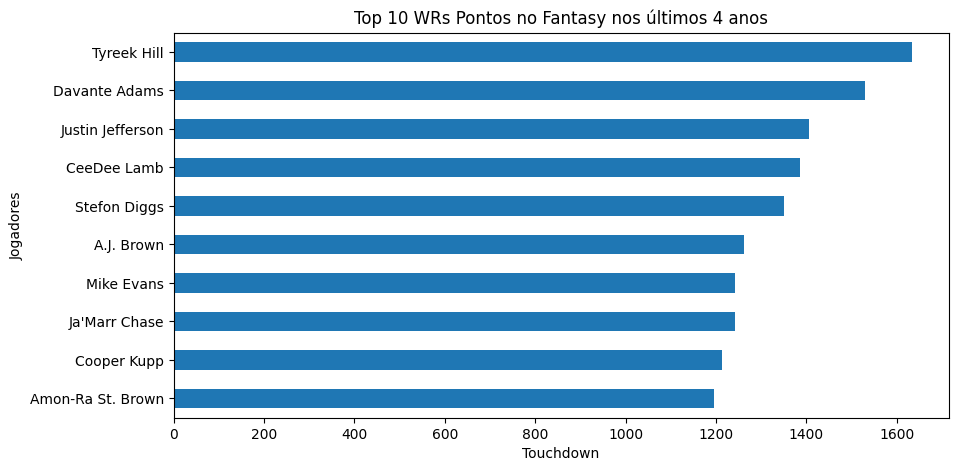

In [476]:
# Top WRs Pontos no Fantasy nos últimos 4 anos
top_wrs_fantasy_recente = top_wrs_recentes.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_wrs_fantasy_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs Pontos no Fantasy nos últimos 4 anos')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

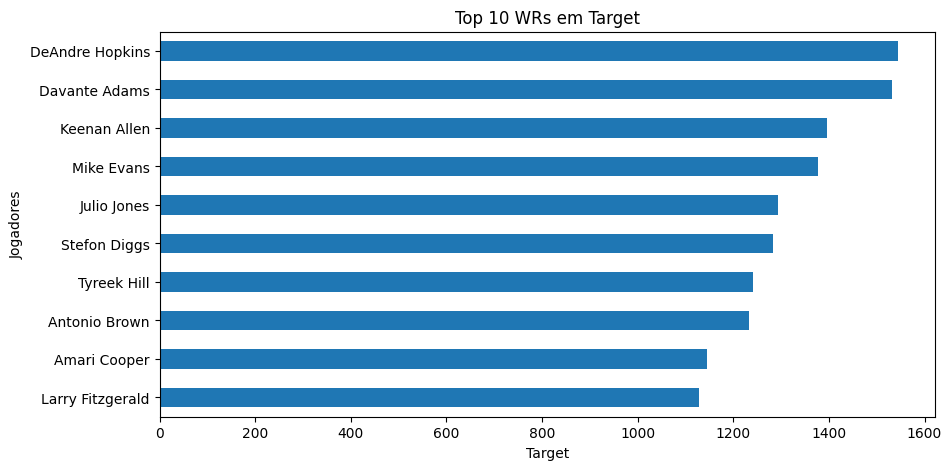

In [477]:
# Top WRs em Target
top_wrs_target = wrs.groupby('player_name')['targets'].sum().nlargest(10)
top_wrs_target.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Target')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()


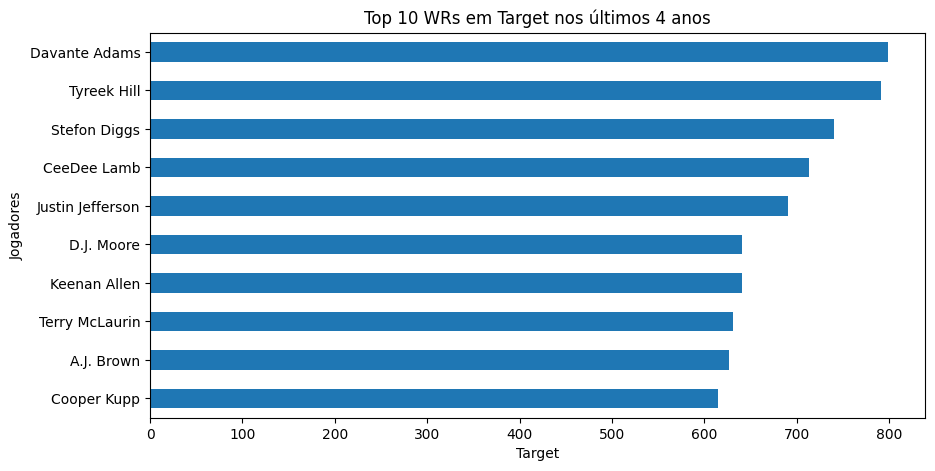

In [478]:
# Top WRs em Target nos últimos 4 anos
top_wrs_target_recentes = top_wrs_recentes.groupby('player_name')['targets'].sum().nlargest(10)
top_wrs_target_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Target nos últimos 4 anos')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()


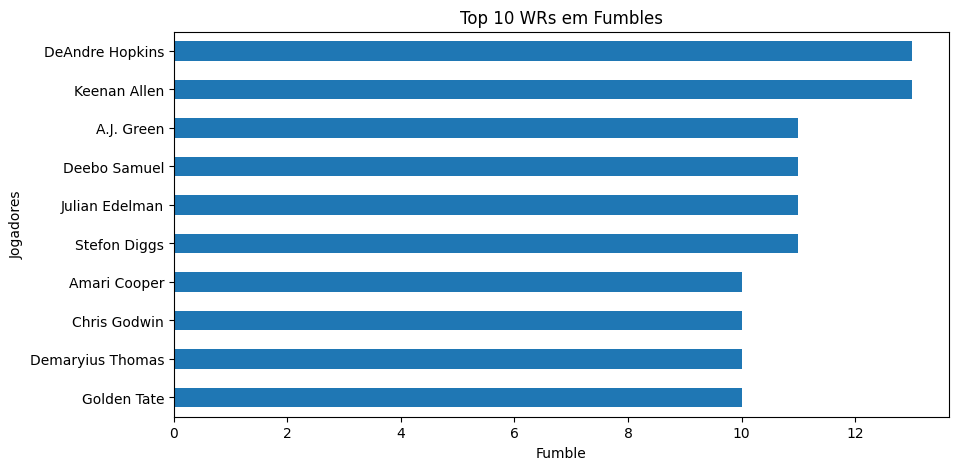

In [479]:
# Top WRs em Fumble
top_wrs_fumble = wrs.groupby('player_name')['fumble'].sum().nlargest(10)
top_wrs_fumble.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Fumbles')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

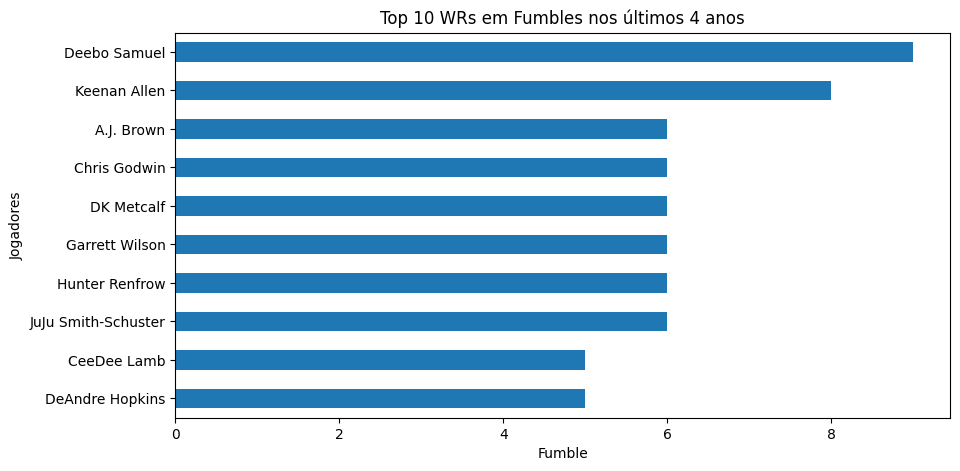

In [480]:
# Top WRs em Fumblee nos últimos 4 anos
top_wrs_fumble_recentes = top_wrs_recentes.groupby('player_name')['fumble'].sum().nlargest(10)
top_wrs_fumble_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Fumbles nos últimos 4 anos')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

####**TE**

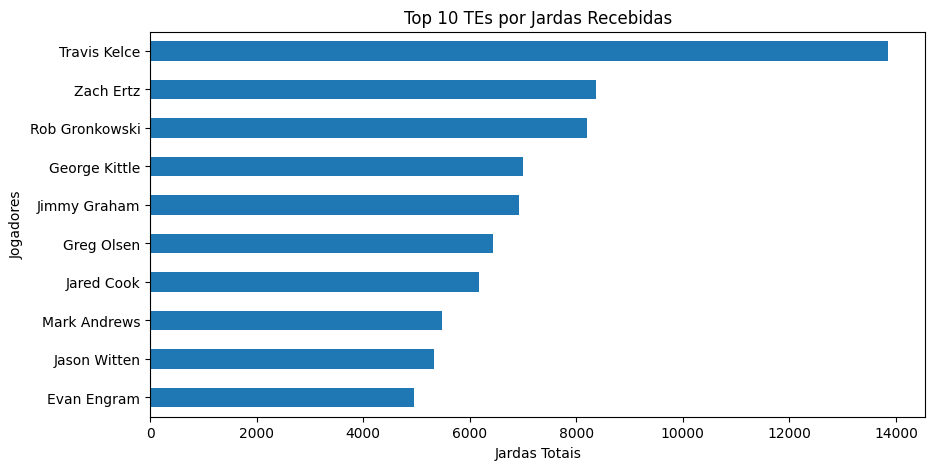

In [481]:
# Top TE em jardas recebidas
tes = df_ataque_limpo[df_ataque_limpo['position'] == 'TE']
top_tes = tes.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_tes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs por Jardas Recebidas')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

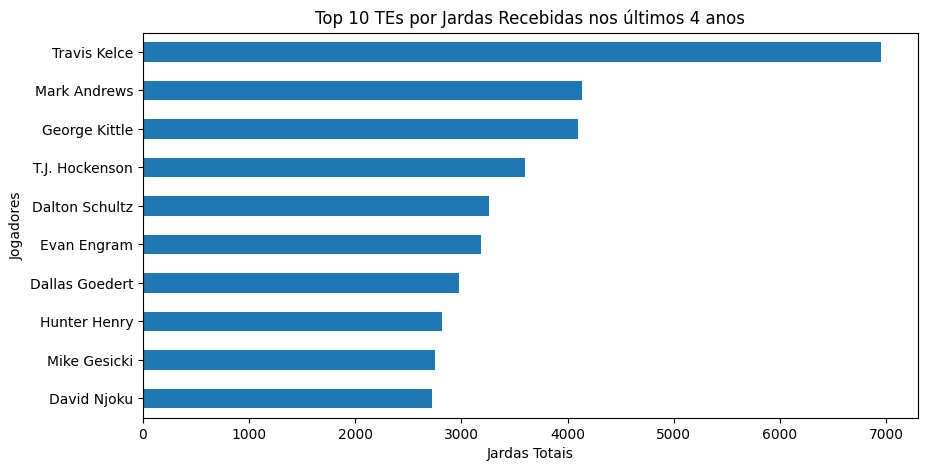

In [482]:
# Top tes em jardas recebidas nos últimos 4 anos
top_tes_recentes = df_ataque_limpo[(df_ataque_limpo['position'] == 'TE') & (df_ataque_limpo['season'] >= 2020)]
top_tes_jardas_recentes = top_tes_recentes.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_tes_jardas_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs por Jardas Recebidas nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

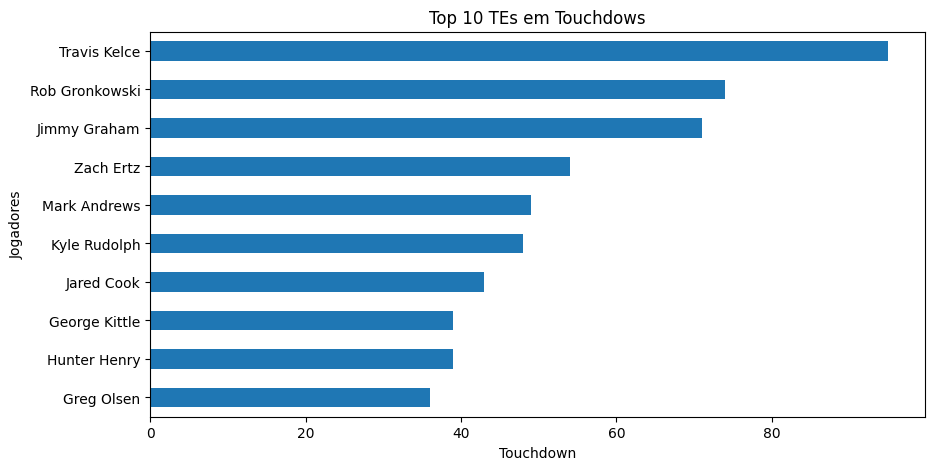

In [483]:
# Top TEs em Tochdowns
top_tes_touch = tes.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_tes_touch.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Touchdows')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

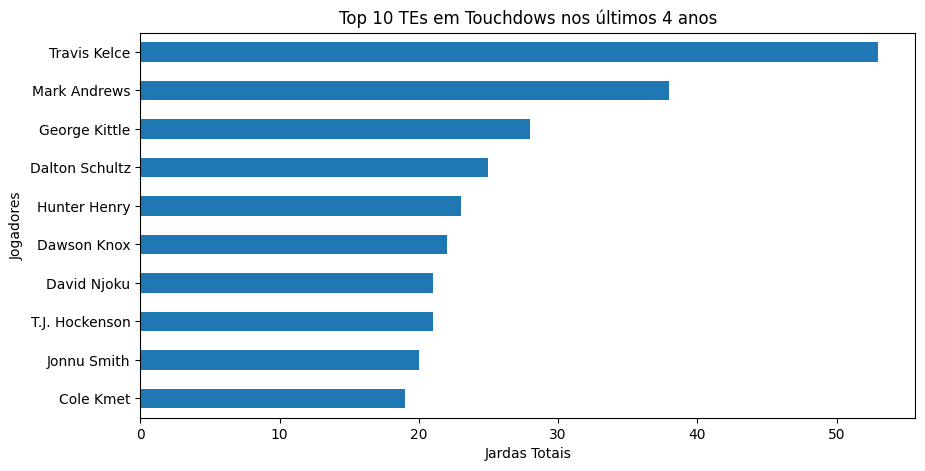

In [484]:
# Top TEs em jardas recebidas nos últimos 4 anos
top_tes_touch_recentes = top_tes_recentes.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_tes_touch_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Touchdows nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

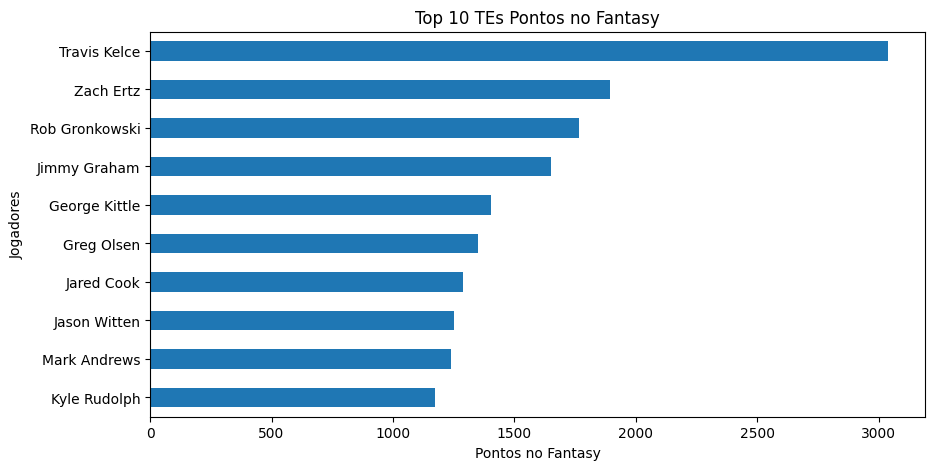

In [485]:
# Top TEs Pontos no Fantasy
top_tes_fantasy = tes.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_tes_fantasy.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs Pontos no Fantasy')
plt.xlabel('Pontos no Fantasy')
plt.ylabel('Jogadores')
plt.show()

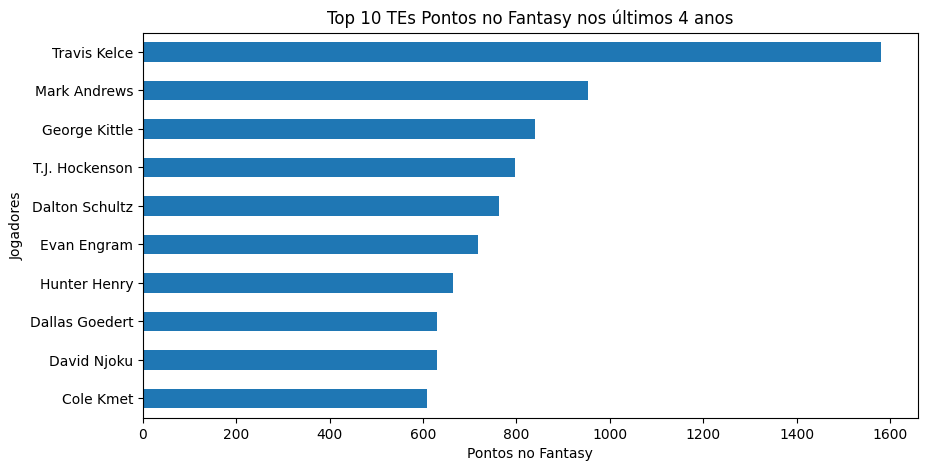

In [486]:
# Top TEs Pontos no Fantasy nos últimos 4 anos
top_tes_fantasy_recente = top_tes_recentes.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_tes_fantasy_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs Pontos no Fantasy nos últimos 4 anos')
plt.xlabel('Pontos no Fantasy')
plt.ylabel('Jogadores')
plt.show()

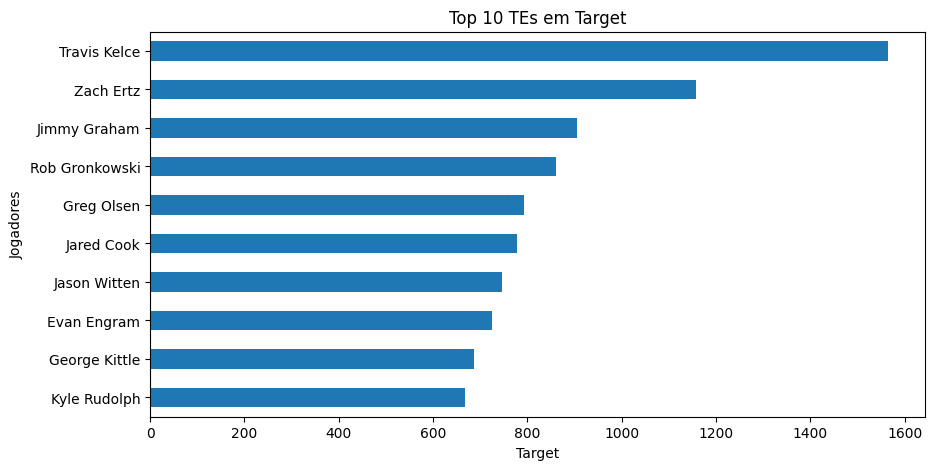

In [487]:
# Top TEs em Target
top_tes_target = tes.groupby('player_name')['targets'].sum().nlargest(10)
top_tes_target.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Target')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()

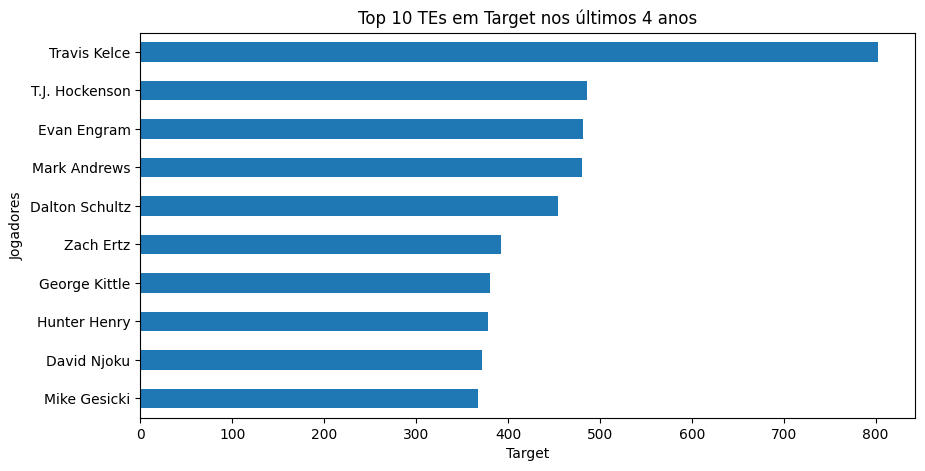

In [488]:
# Top TEs em Target nos últimos 4 anos
top_tes_target_recentes = top_tes_recentes.groupby('player_name')['targets'].sum().nlargest(10)
top_tes_target_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Target nos últimos 4 anos')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()

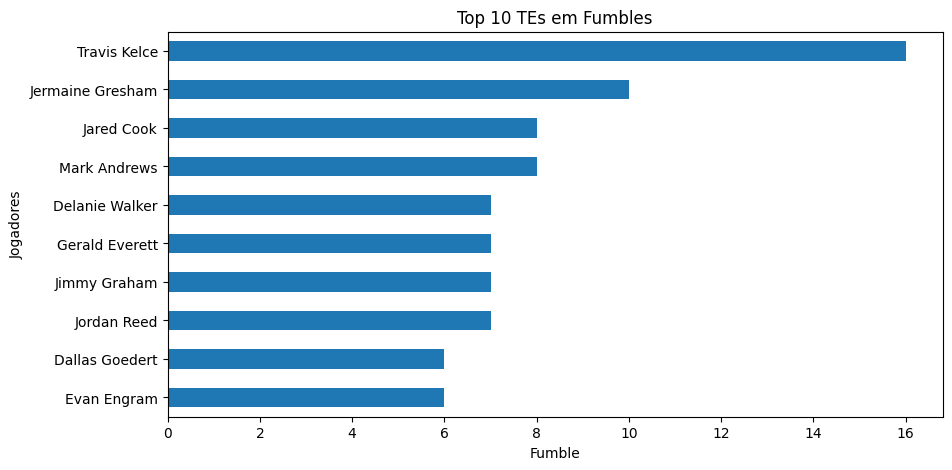

In [489]:
# Top TEs em Fumble
top_tes_fumble = tes.groupby('player_name')['fumble'].sum().nlargest(10)
top_tes_fumble.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Fumbles')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

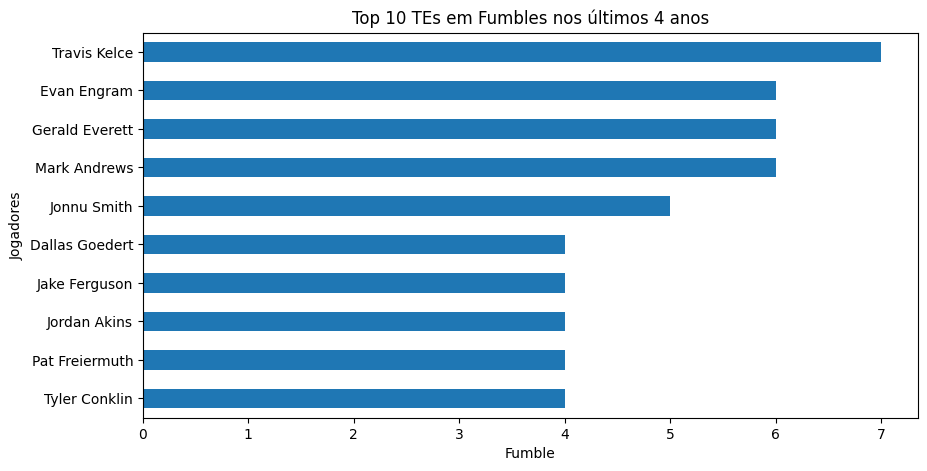

In [490]:
# Top TEs em Fumblee nos últimos 4 anos
top_tes_fumble_recentes = top_tes_recentes.groupby('player_name')['fumble'].sum().nlargest(10)
top_tes_fumble_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Fumbles nos últimos 4 anos')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

####**RB**

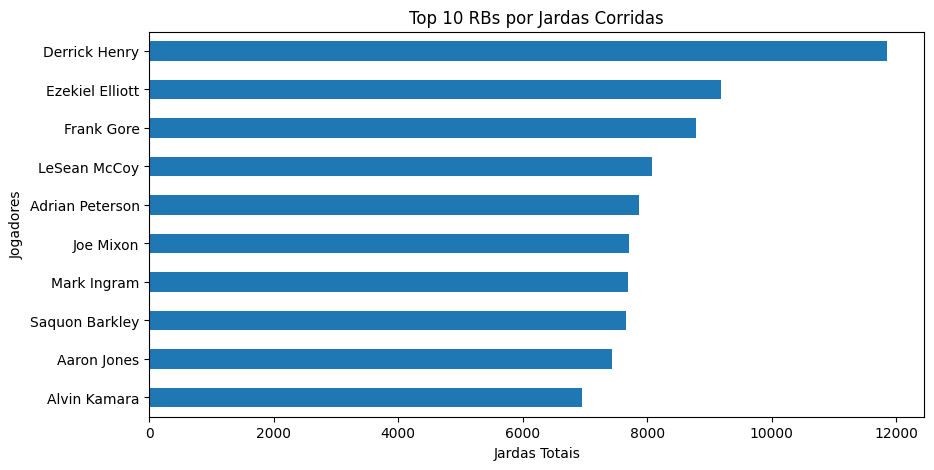

In [491]:
# Top rbs em jardas corridas
rbs = df_ataque_limpo[df_ataque_limpo['position'] == 'RB']
top_rbs = rbs.groupby('player_name')['rushing_yards'].sum().nlargest(10)
top_rbs.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs por Jardas Corridas')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

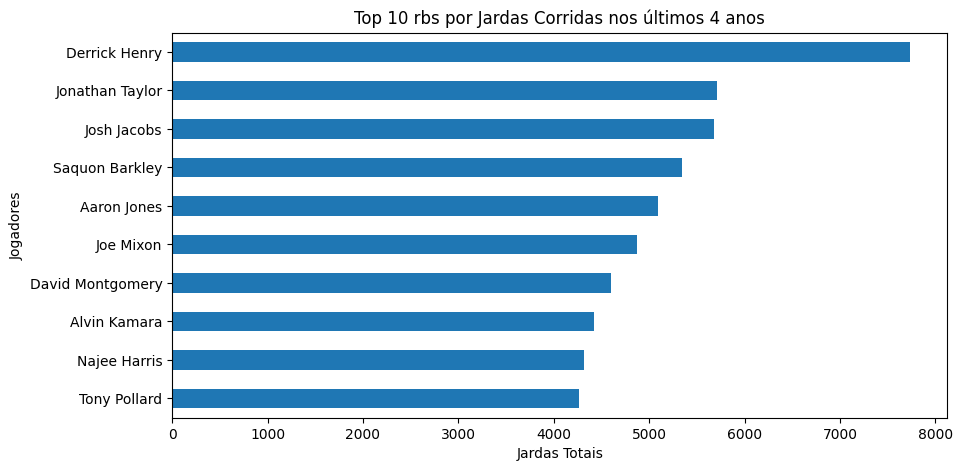

In [492]:
# Top rbs em jardas recebidas nos últimos 4 anos
top_rbs_recenrbs = df_ataque_limpo[(df_ataque_limpo['position'] == 'RB') & (df_ataque_limpo['season'] >= 2020)]
top_rbs_jardas_recentes = top_rbs_recenrbs.groupby('player_name')['rushing_yards'].sum().nlargest(10)
top_rbs_jardas_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 rbs por Jardas Corridas nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

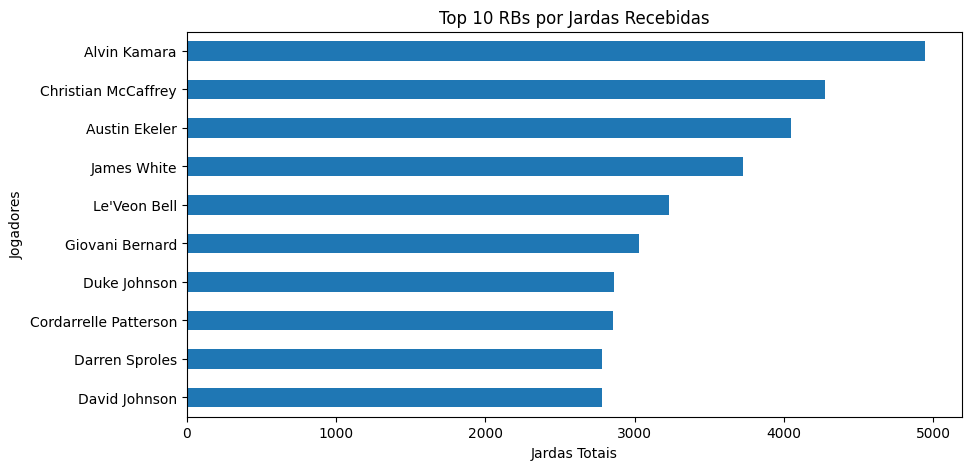

In [493]:
# Top RBs em jardas recebidas
rbs = df_ataque_limpo[df_ataque_limpo['position'] == 'RB']
top_rbs = rbs.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_rbs.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs por Jardas Recebidas')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

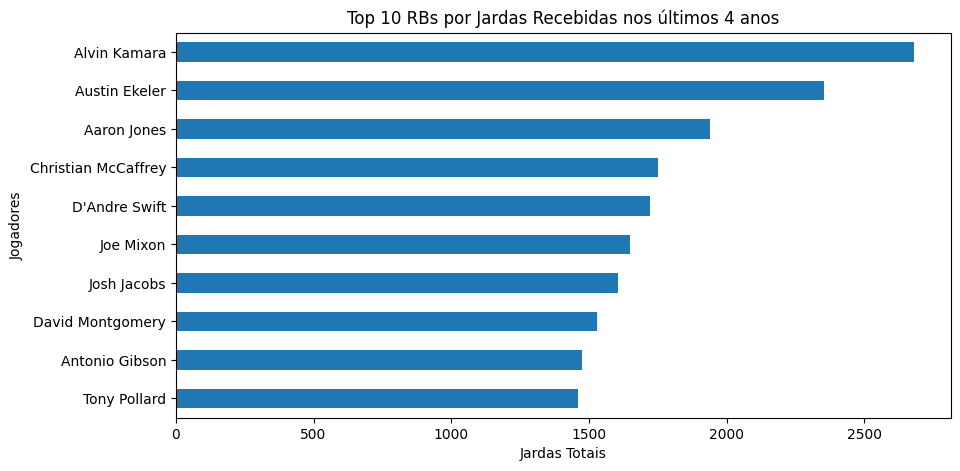

In [494]:
# Top RBs em jardas recebidas nos últimos 4 anos
top_rbs_recentes = df_ataque_limpo[(df_ataque_limpo['position'] == 'RB') & (df_ataque_limpo['season'] >= 2020)]
top_rbs_jardas_recentes = top_rbs_recentes.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_rbs_jardas_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs por Jardas Recebidas nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

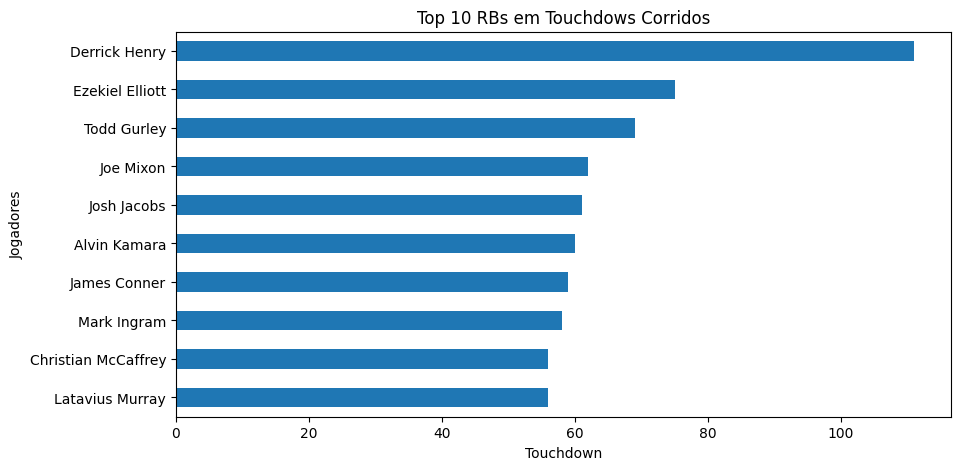

In [495]:
# Top RBs em Tochdowns Corridos
top_rbs_rush_td = rbs.groupby('player_name')['rush_touchdown'].sum().nlargest(10)
top_rbs_rush_td.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Touchdows Corridos')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

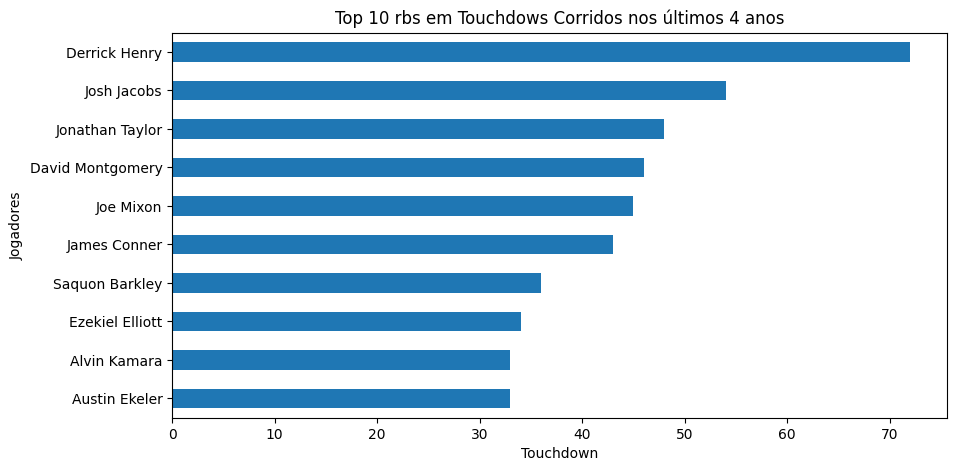

In [496]:
# Top rbs em Touchdown corridos nos últimos 4 anos
top_rbs_rush_td_recentes = top_rbs_recentes.groupby('player_name')['rush_touchdown'].sum().nlargest(10)
top_rbs_rush_td_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 rbs em Touchdows Corridos nos últimos 4 anos')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

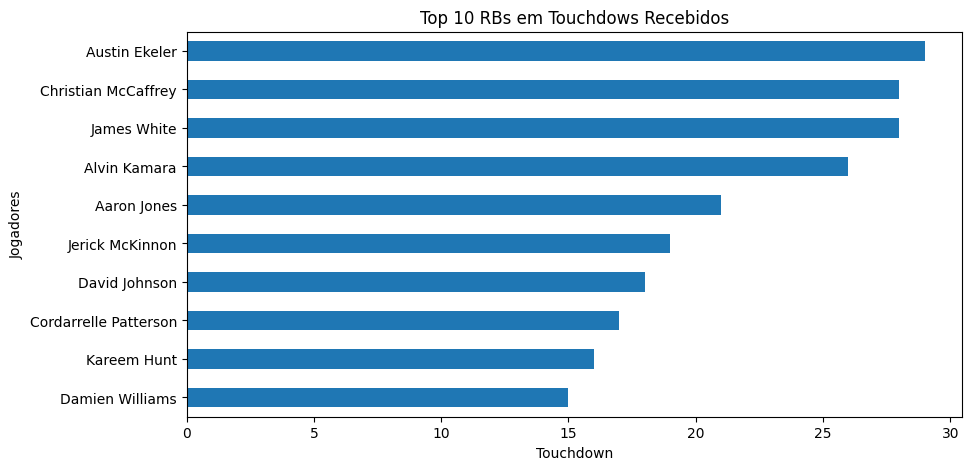

In [497]:
# Top RBs em Tochdowns Recebidos
top_rbs_td_receb = rbs.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_rbs_td_receb.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Touchdows Recebidos')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

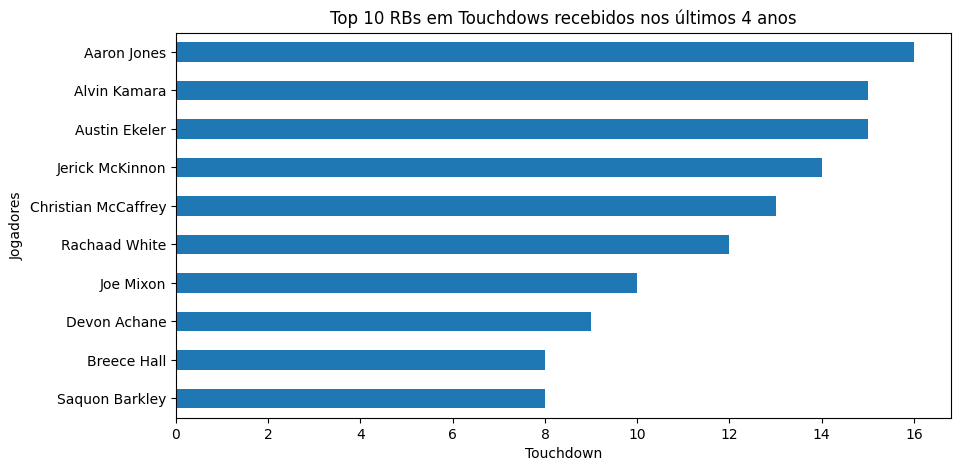

In [498]:
# Top RBs em Tochdowns recebidos nos últimos 4 anos
top_rbs_td_receb_recentes = top_rbs_recentes.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_rbs_td_receb_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Touchdows recebidos nos últimos 4 anos')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

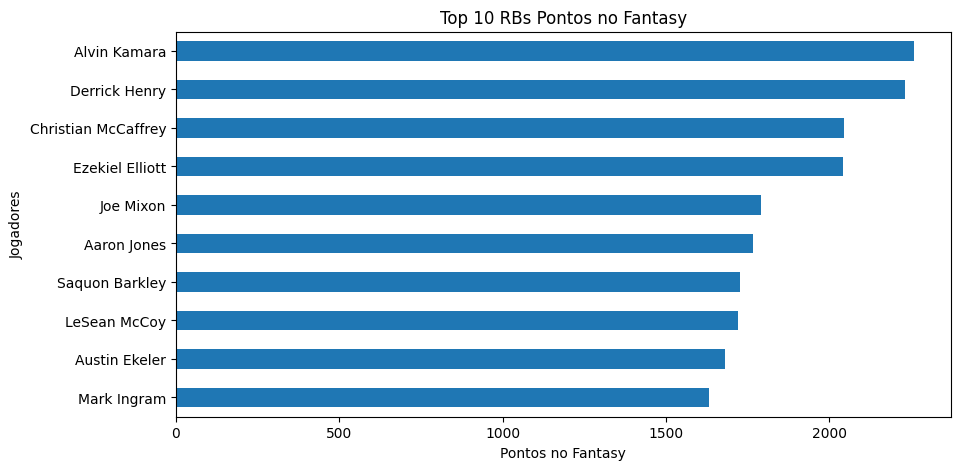

In [499]:
# Top rbs Pontos no Fantasy
top_rbs_fantasy = rbs.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_rbs_fantasy.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs Pontos no Fantasy')
plt.xlabel('Pontos no Fantasy')
plt.ylabel('Jogadores')
plt.show()

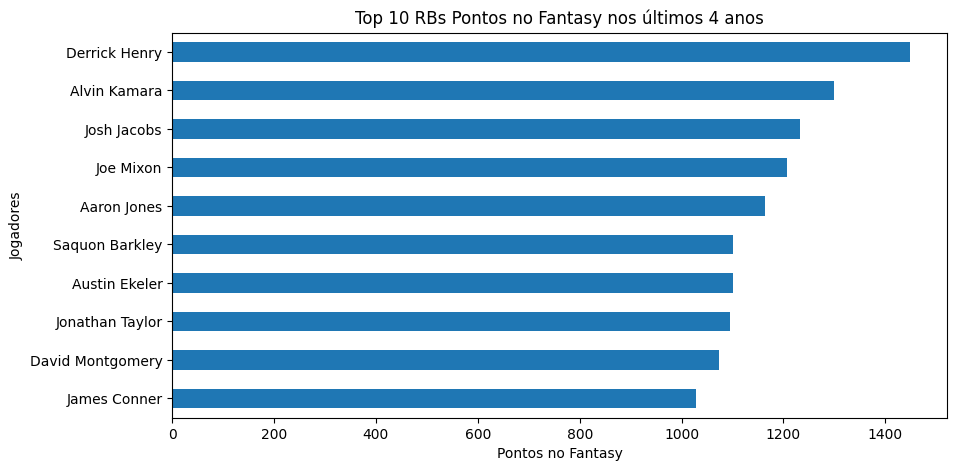

In [500]:
# Top rbs Pontos no Fantasy nos últimos 4 anos
top_rbs_fantasy_recenrb = top_rbs_recentes.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_rbs_fantasy_recenrb.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs Pontos no Fantasy nos últimos 4 anos')
plt.xlabel('Pontos no Fantasy')
plt.ylabel('Jogadores')
plt.show()

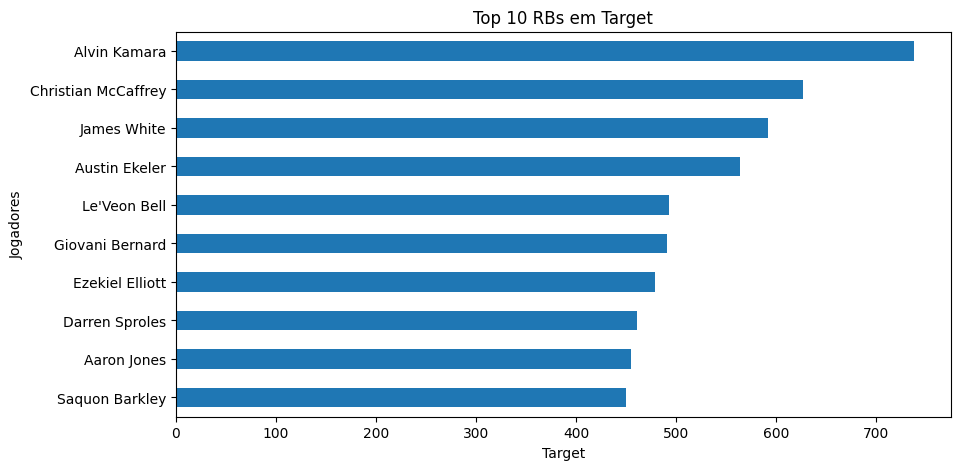

In [501]:
# Top rbs em Target
top_rbs_target = rbs.groupby('player_name')['targets'].sum().nlargest(10)
top_rbs_target.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Target')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()

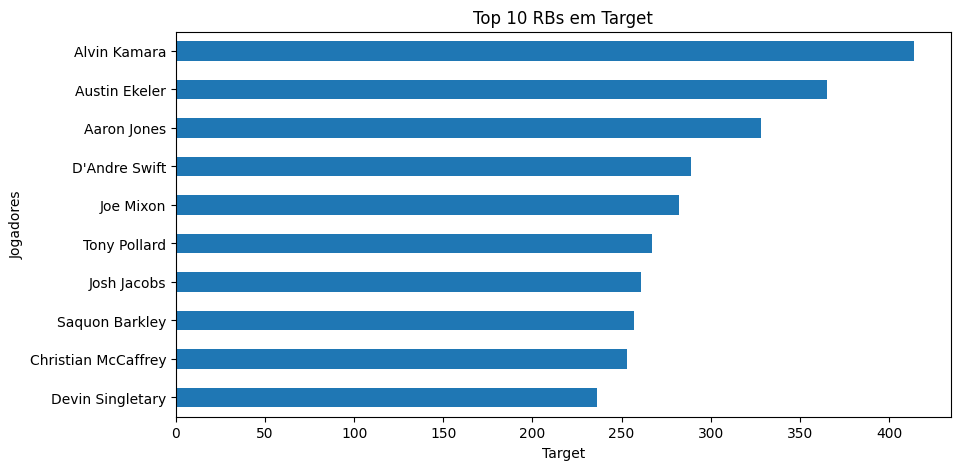

In [502]:
# Top rbs em Target nos últimos 4 anos
top_rbs_target_recentes = top_rbs_recentes.groupby('player_name')['targets'].sum().nlargest(10)
top_rbs_target_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Target')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()

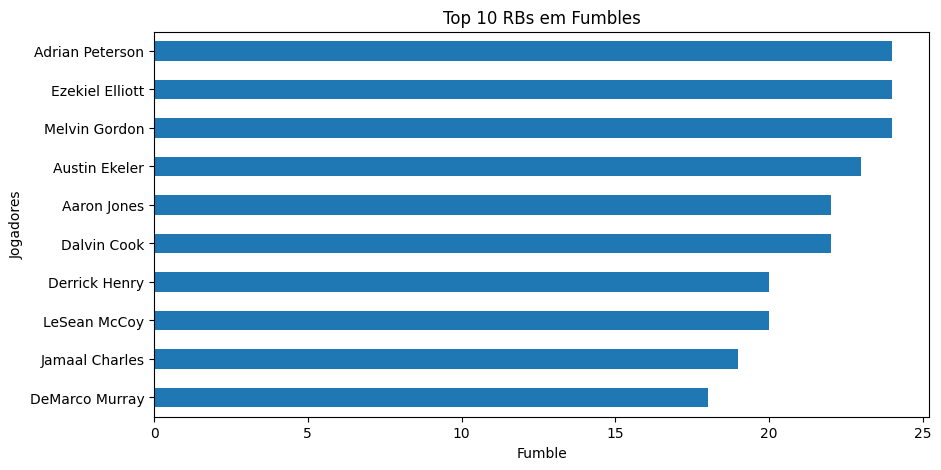

In [503]:
# Top rbs em Fumble
top_rbs_fumble = rbs.groupby('player_name')['fumble'].sum().nlargest(10)
top_rbs_fumble.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Fumbles')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

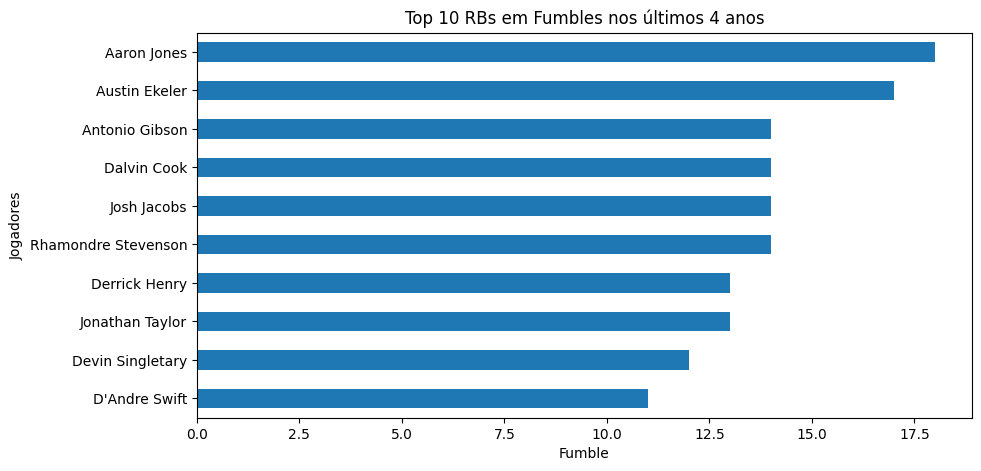

In [504]:
# Top rbs em Fumblee nos últimos 4 anos
top_rbs_fumble_recentes = top_rbs_recentes.groupby('player_name')['fumble'].sum().nlargest(10)
top_rbs_fumble_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Fumbles nos últimos 4 anos')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

TDs aéreos: 2012 → 2024
Total TDs na primeira temporada: 1364
Total TDs na última temporada: 1592
Variação percentual entre primeira e última: 16.7%


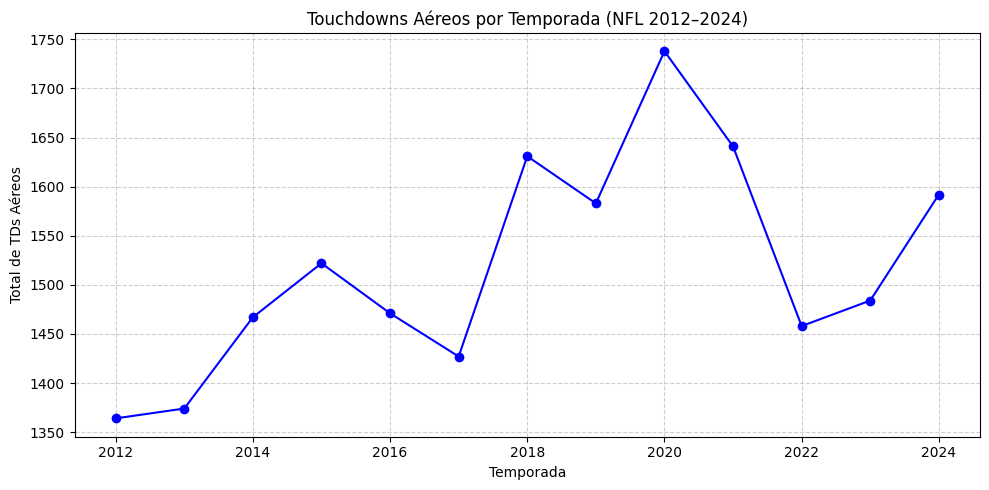

In [505]:
# Agrupando touchdowns de passe por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['pass_touchdown']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['pass_touchdown'].iloc[0], td_por_temporada['pass_touchdown'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"TDs aéreos: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total TDs na primeira temporada: {primeira:.0f}")
print(f"Total TDs na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['pass_touchdown'], marker='o', color='blue')
plt.title('Touchdowns Aéreos por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Total de TDs Aéreos')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



TDs aéreos: 2012 → 2024
Total TDs na primeira temporada: 347
Total TDs na última temporada: 524
Variação percentual entre primeira e última: 51.0%


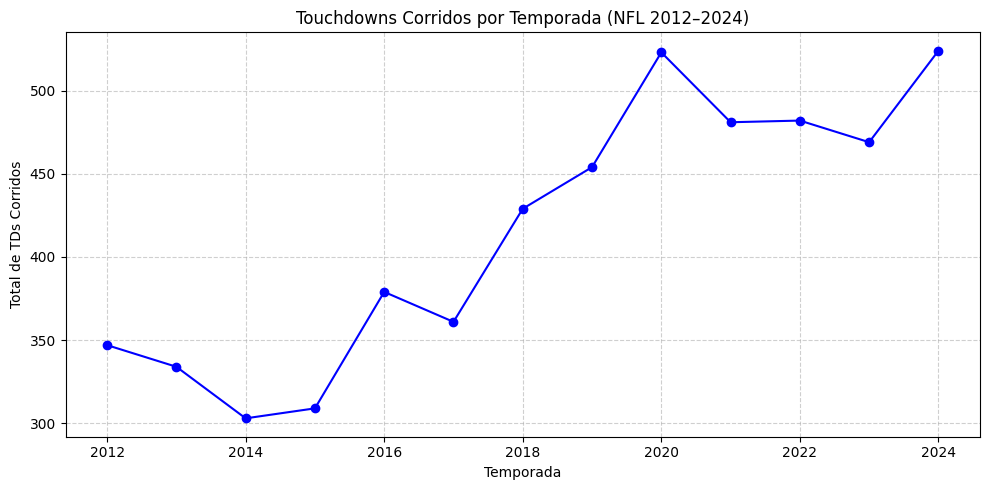

In [506]:
# Agrupando touchdowns de corrida por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['rush_touchdown']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['rush_touchdown'].iloc[0], td_por_temporada['rush_touchdown'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"TDs aéreos: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total TDs na primeira temporada: {primeira:.0f}")
print(f"Total TDs na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['rush_touchdown'], marker='o', color='blue')
plt.title('Touchdowns Corridos por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Total de TDs Corridos')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

TDs totais: 2012 → 2024
Total TDs na primeira temporada: 1711
Total TDs na última temporada: 2116
Variação percentual entre primeira e última: 23.7%


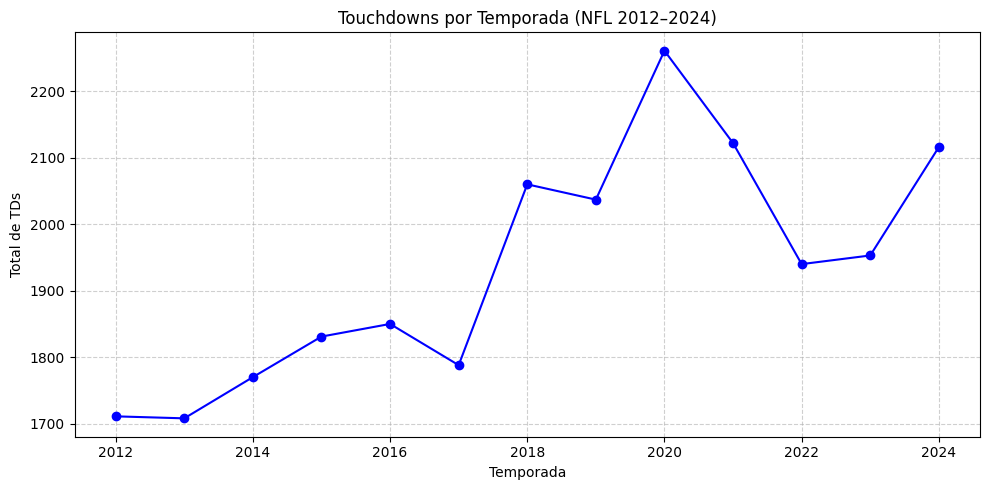

In [507]:
# Agrupando touchdowns por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['total_touchdown']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['total_touchdown'].iloc[0], td_por_temporada['total_touchdown'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"TDs totais: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total TDs na primeira temporada: {primeira:.0f}")
print(f"Total TDs na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['total_touchdown'], marker='o', color='blue')
plt.title('Touchdowns por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Total de TDs')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Passes completados totais: 2012 → 2024
Total de passes completados na primeira temporada: 10286
Total de passes completados na última temporada: 11807
Variação percentual entre primeira e última: 14.8%


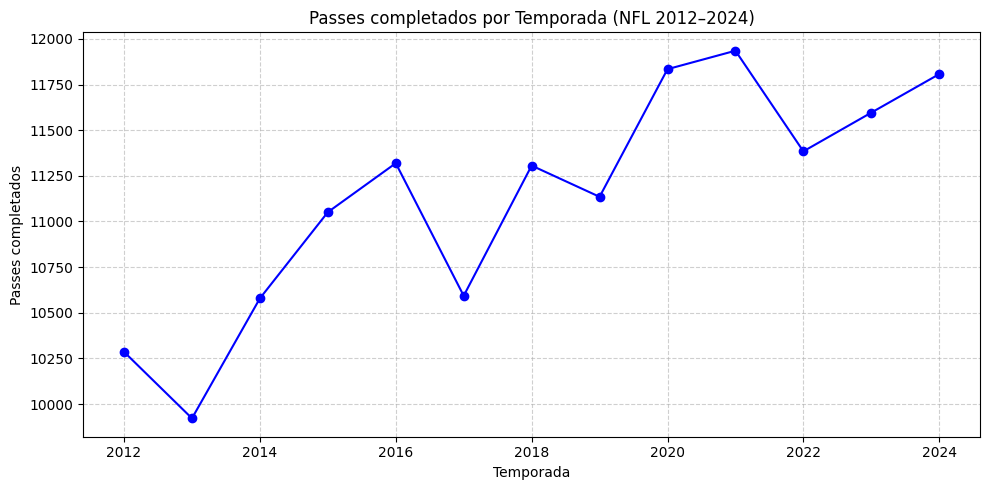

In [508]:
# Agrupando por passes completados por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['complete_pass']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['complete_pass'].iloc[0], td_por_temporada['complete_pass'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Passes completados totais: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total de passes completados na primeira temporada: {primeira:.0f}")
print(f"Total de passes completados na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['complete_pass'], marker='o', color='blue')
plt.title('Passes completados por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Passes completados')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Tentativa de corrida totais: 2012 → 2024
Total de tentativa de corridas na primeira temporada: 11747
Total de tentativa de corridas na última temporada: 14266
Variação percentual entre primeira e última: 21.4%


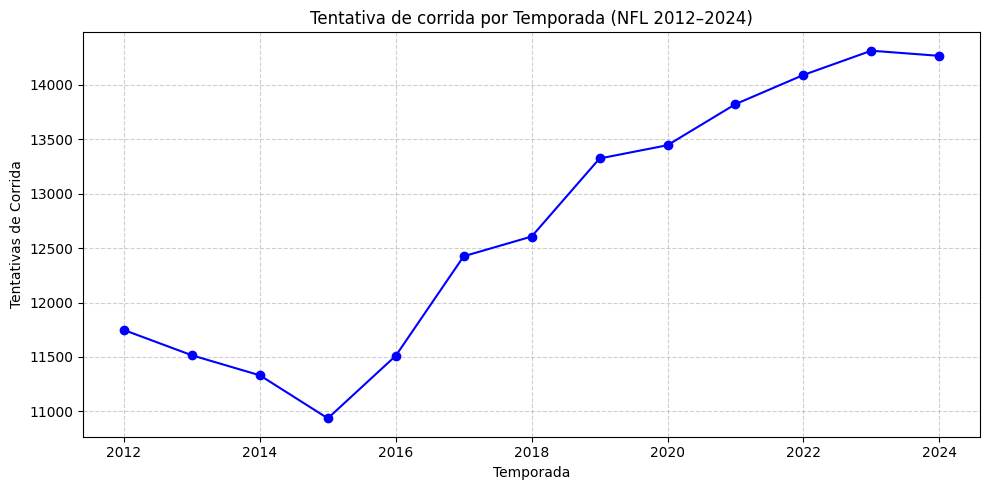

In [509]:
# Agrupando por tentativas de corridas por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['rush_attempts']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['rush_attempts'].iloc[0], td_por_temporada['rush_attempts'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Tentativa de corrida totais: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total de tentativa de corridas na primeira temporada: {primeira:.0f}")
print(f"Total de tentativa de corridas na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['rush_attempts'], marker='o', color='blue')
plt.title('Tentativa de corrida por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Tentativas de Corrida')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Jardas por carregada totais: 2012 → 2024
Total de Jardas por carregada na primeira temporada: 1042
Total de Jardas por carregada na última temporada: 1331
Variação percentual entre primeira e última: 27.6%


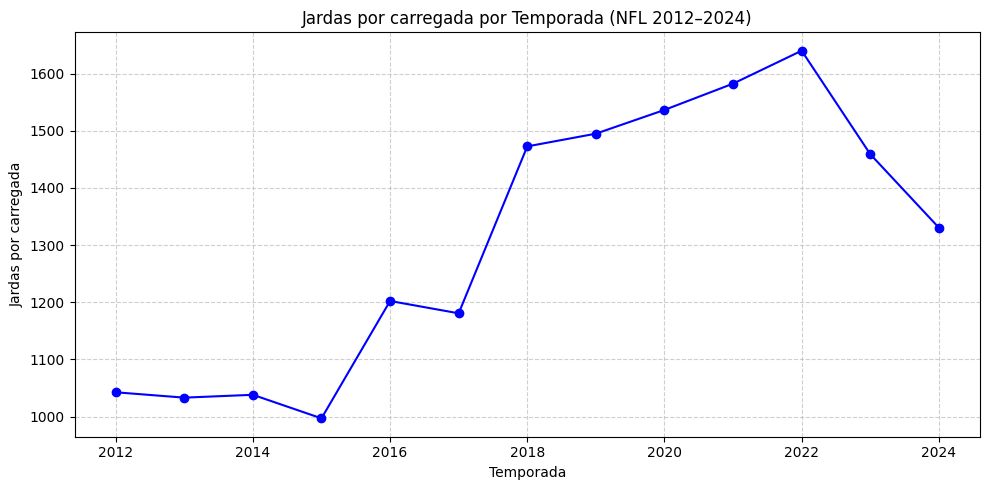

In [510]:
# Agrupando por jardas por carregada por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['yards_per_carry']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['yards_per_carry'].iloc[0], td_por_temporada['yards_per_carry'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Jardas por carregada totais: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total de Jardas por carregada na primeira temporada: {primeira:.0f}")
print(f"Total de Jardas por carregada na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['yards_per_carry'], marker='o', color='blue')
plt.title('Jardas por carregada por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Jardas por carregada')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Jardas por recepção totais: 2012 → 2024
Total de Jardas por recepção na primeira temporada: 3610
Total de Jardas por recepção na última temporada: 4677
Variação percentual entre primeira e última: 29.6%


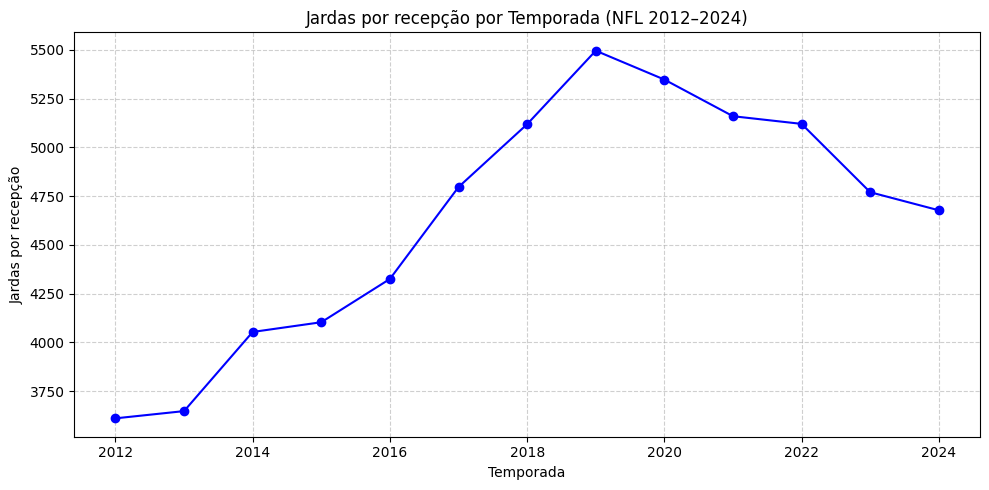

In [511]:
# Agrupando por jardas por recepção por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['yards_per_reception']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['yards_per_reception'].iloc[0], td_por_temporada['yards_per_reception'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Jardas por recepção totais: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total de Jardas por recepção na primeira temporada: {primeira:.0f}")
print(f"Total de Jardas por recepção na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['yards_per_reception'], marker='o', color='blue')
plt.title('Jardas por recepção por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Jardas por recepção')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Taxa de recepção: 2012 → 2024
Total de taxa por recepção na primeira temporada: 224
Total de taxa por recepção na última temporada: 331
Variação percentual entre primeira e última: 48.0%


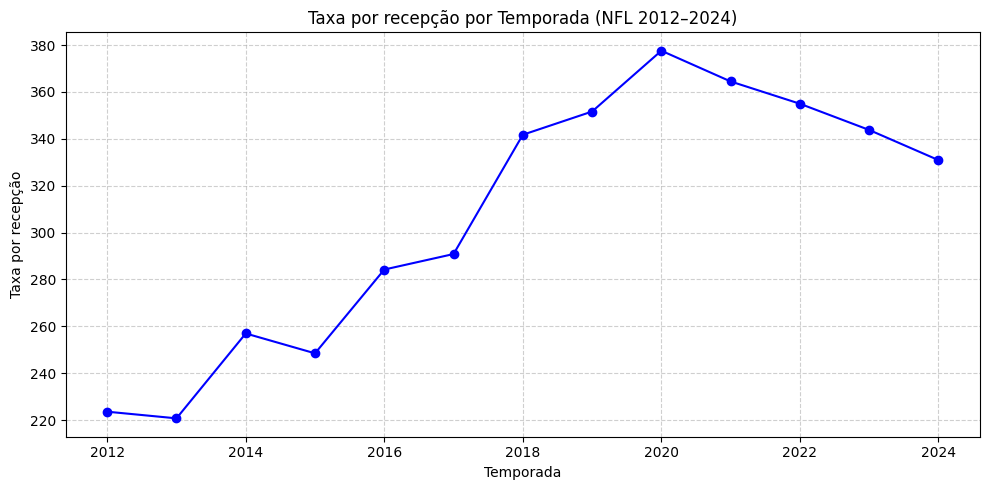

In [512]:
# Agrupando por taxa por recepção por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['catch_rate']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['catch_rate'].iloc[0], td_por_temporada['catch_rate'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Taxa de recepção: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total de taxa por recepção na primeira temporada: {primeira:.0f}")
print(f"Total de taxa por recepção na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['catch_rate'], marker='o', color='blue')
plt.title('Taxa por recepção por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Taxa por recepção')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

###**Defesa**

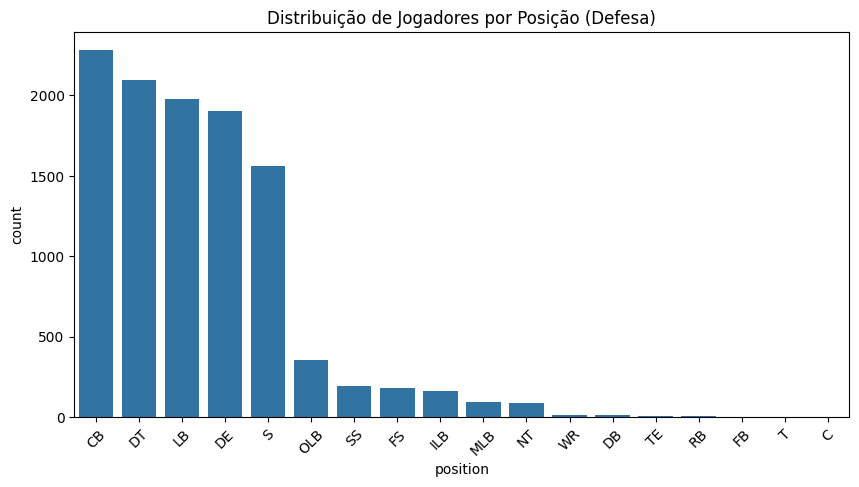

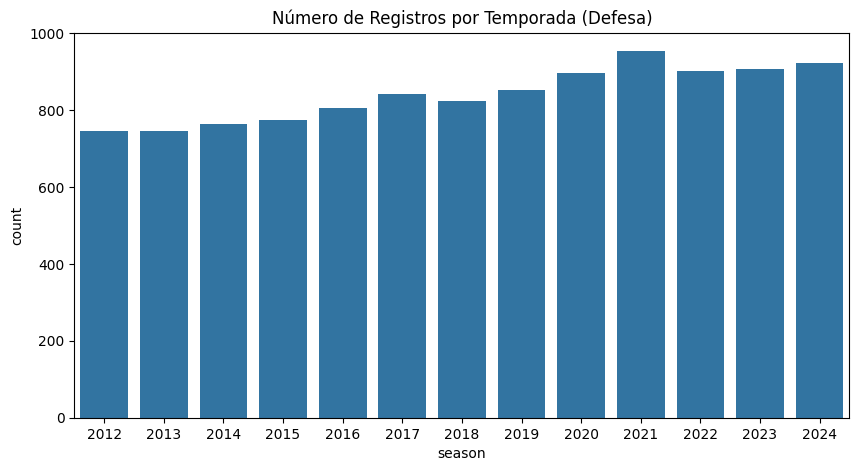

In [513]:
# Gráfico para verificar a distribuição dos jogadores por posição
plt.figure(figsize=(10,5))
sns.countplot(data=df_defesa_limpo, x='position', order=df_defesa_limpo['position'].value_counts().index)
plt.title('Distribuição de Jogadores por Posição (Defesa)')
plt.xticks(rotation=45)
plt.show()

# Número de registros por temporada
plt.figure(figsize=(10,5))
sns.countplot(data=df_defesa_limpo, x='season')
plt.title('Número de Registros por Temporada (Defesa)')
plt.show()

In [514]:
# Estatísticas da defesa
df_defesa_limpo.describe()[['tackles_total', 'sack', 'qb_hit', 'interception', 'fumble_forced', 'def_touchdown', 'impact_plays']]

tackles_total          sack        qb_hit  interception  fumble_forced  \
count   10939.000000  10939.000000  10939.000000  10939.000000   10939.000000   
mean       42.291251      5.756742      8.497669      1.126794       1.401225   
std        37.987574     10.372226     12.726330      2.165175       2.703147   
min         0.000000      0.000000      0.000000      0.000000       0.000000   
25%        10.000000      0.000000      1.000000      0.000000       0.000000   
50%        33.000000      0.000000      4.000000      0.000000       0.000000   
75%        64.000000      7.000000     10.000000      2.000000       2.000000   
max       231.000000     92.000000    112.000000     22.000000      33.000000   

       def_touchdown  impact_plays  
count   10939.000000  10939.000000  
mean        0.161075      8.493555  
std         0.620856     12.608796  
min         0.000000      0.000000  
25%         0.000000      0.000000  
50%         0.000000      4.000000  
75%         0.000000     11.000000  
max        10.000000    111.000000

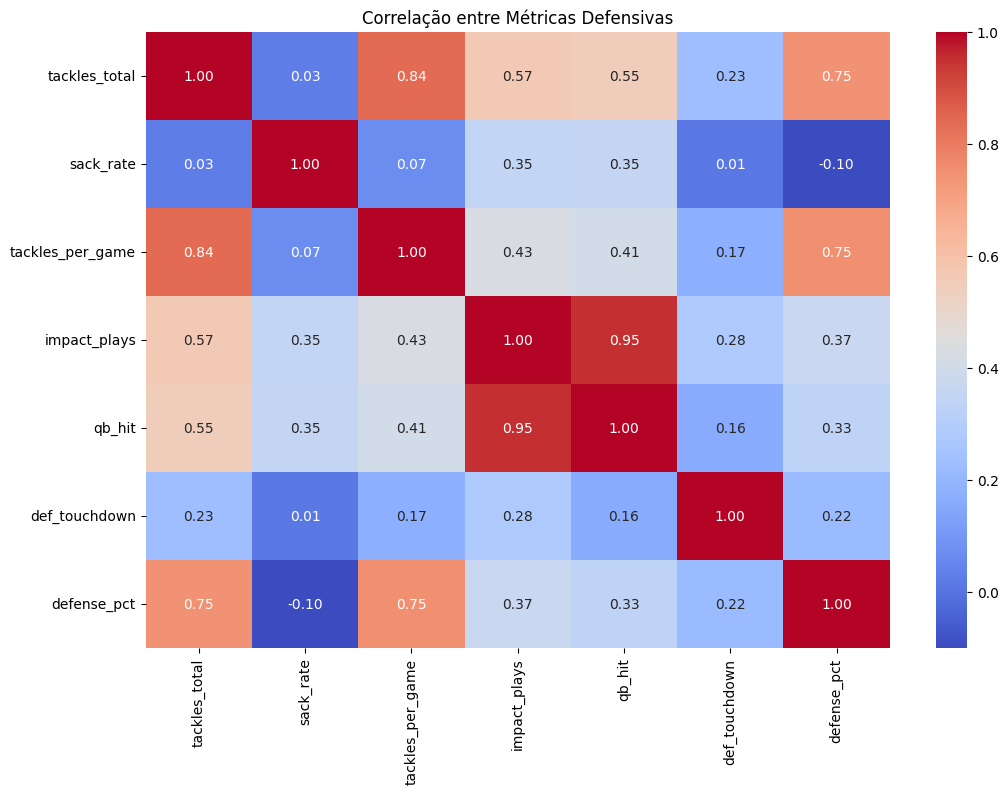

In [515]:
# Correlação entre variáveis
corr_cols = ['tackles_total', 'sack_rate', 'tackles_per_game', 'impact_plays',
             'qb_hit',  'def_touchdown', 'defense_pct']
plt.figure(figsize=(12, 8))
sns.heatmap(df_defesa_limpo[corr_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação entre Métricas Defensivas')
plt.show()

####**CBs (DBs)**

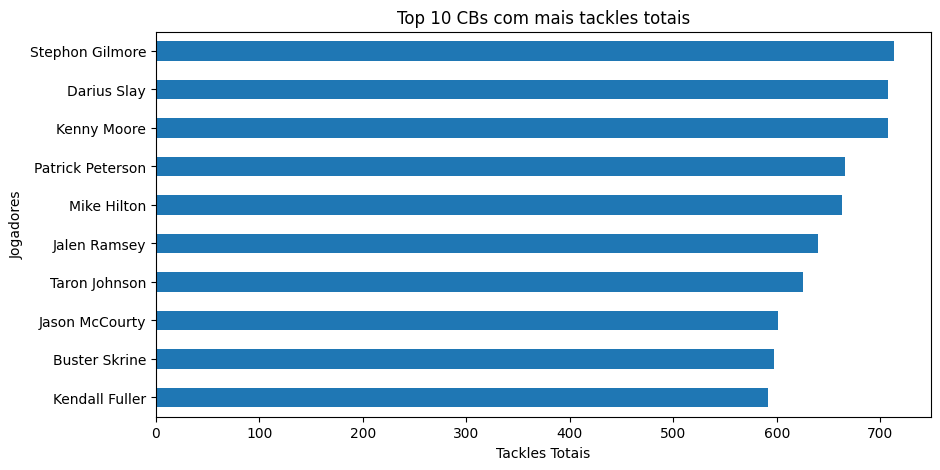

In [516]:
# Top CBs com mais tackles totais
cbs = df_defesa_limpo[(df_defesa_limpo['position'] == 'CB') | (df_defesa_limpo['position'] == 'DB')]
top_cbs_tackles = cbs.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_cbs_tackles.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 CBs com mais tackles totais')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

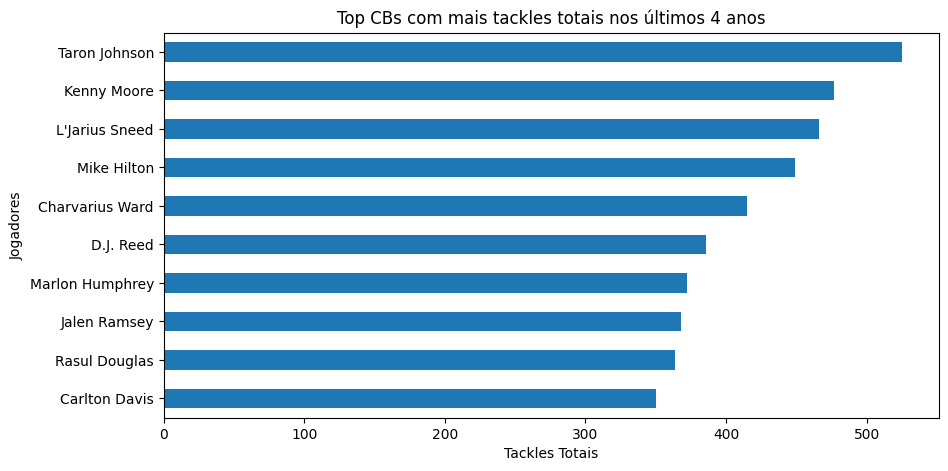

In [517]:
# Top CBs com mais tackles totais nos últimos 4 anos
cbs_recentes = df_defesa_limpo[((df_defesa_limpo['position'] == 'CB') | (df_defesa_limpo['position'] == 'DB')) & (df_defesa_limpo['season'] >= 2020)]
top_cbs_tackles_recente = cbs_recentes.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_cbs_tackles_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top CBs com mais tackles totais nos últimos 4 anos')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

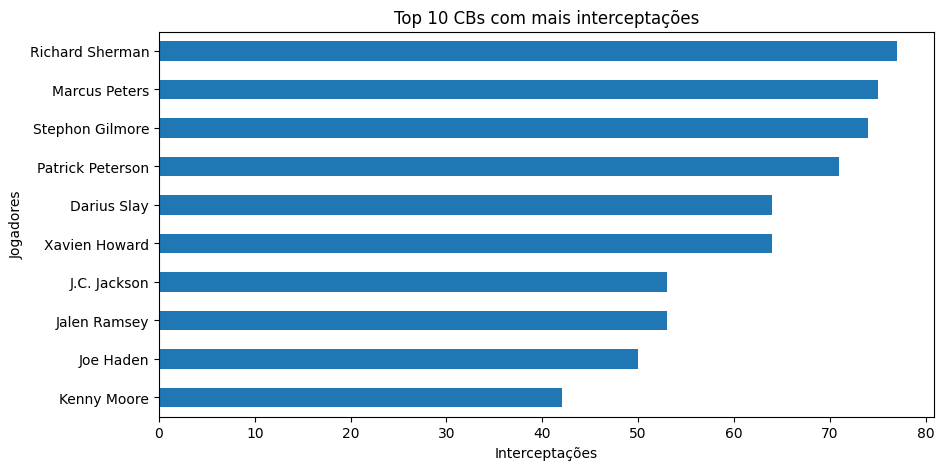

In [518]:
# Top CBs com mais interceptações
top_cbs_int = cbs.groupby('player_name')['interception'].sum().nlargest(10)
top_cbs_int.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 CBs com mais interceptações')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

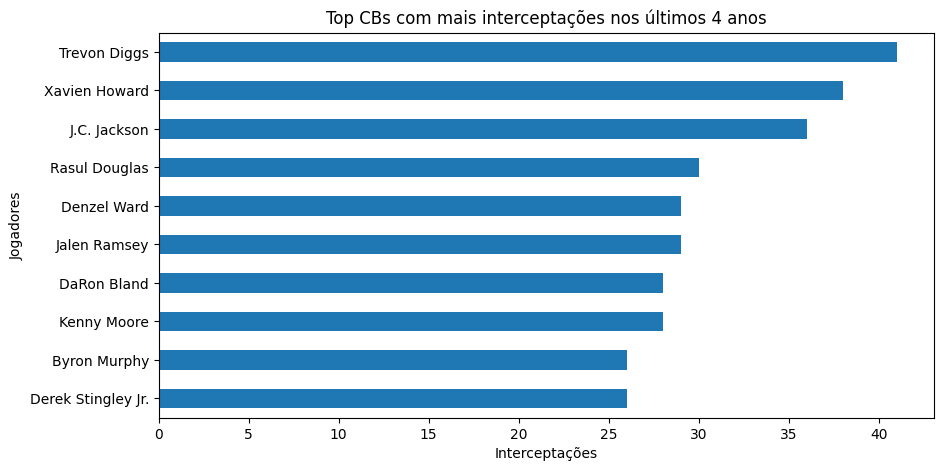

In [519]:
# Top CBs com mais interceptações nos últimos 4 anos
top_cbs_int_recente = cbs_recentes.groupby('player_name')['interception'].sum().nlargest(10)
top_cbs_int_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top CBs com mais interceptações nos últimos 4 anos')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

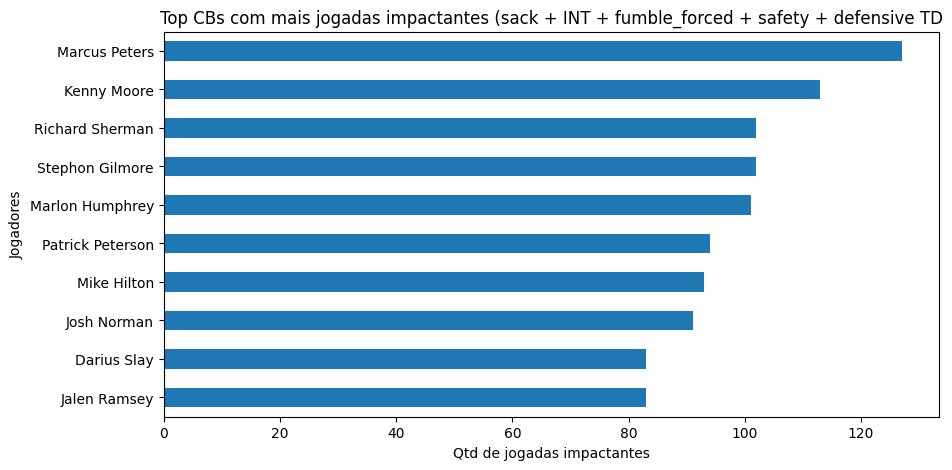

In [520]:
# Top CBs com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD)
top_cbs_impact = cbs.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_cbs_impact.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top CBs com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

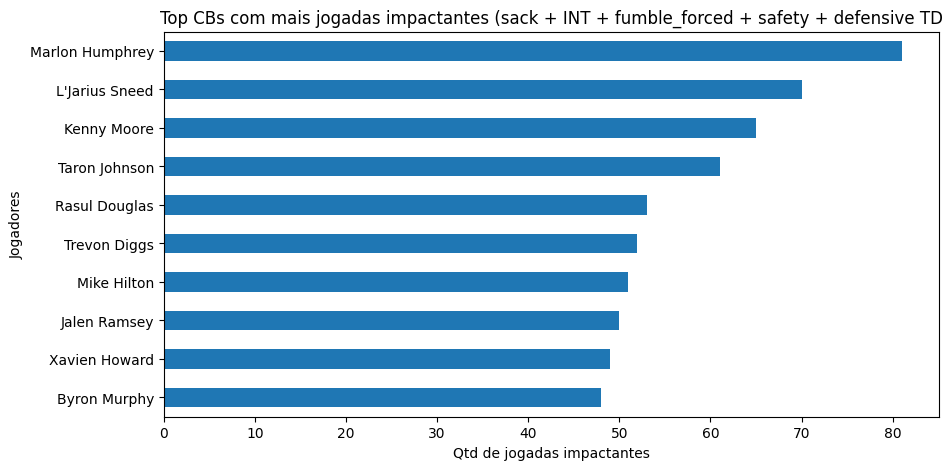

In [521]:
# Top CBs com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD) nos últimos 4 anos
top_cbs_impact_recente = cbs_recentes.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_cbs_impact_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top CBs com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

####**Safeties(FS, SS, S)**

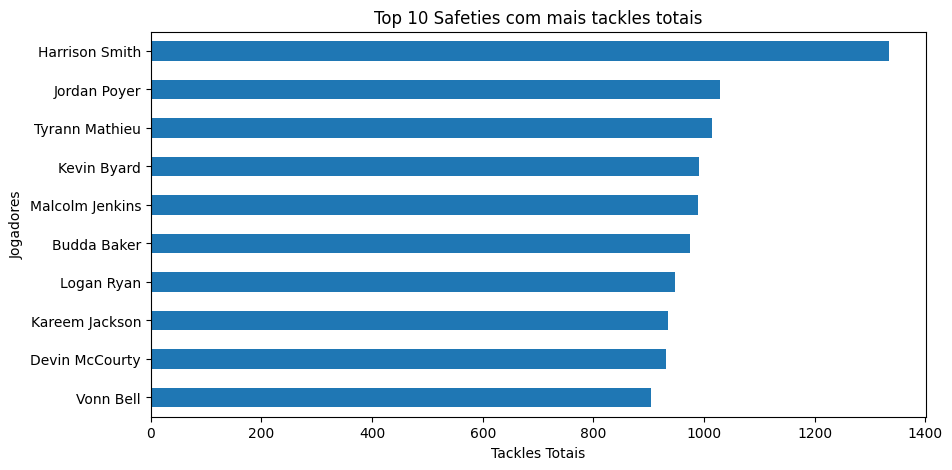

In [522]:
# Top Safeties com mais tackles totais
safeties = df_defesa_limpo[(df_defesa_limpo['position'] == 'FS') | (df_defesa_limpo['position'] == 'SS') | (df_defesa_limpo['position'] == 'S')]
top_safeties_tackles = safeties.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_safeties_tackles.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Safeties com mais tackles totais')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

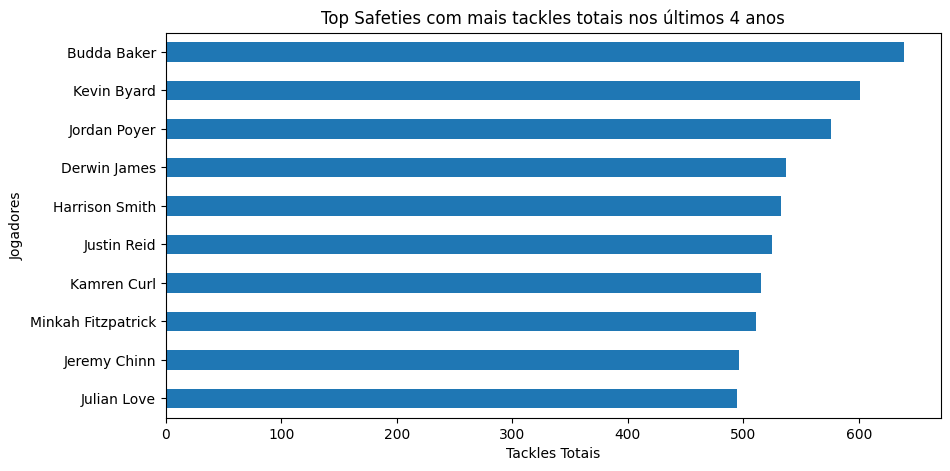

In [523]:
# Top CBs com mais tackles totais nos últimos 4 anos
safeties_recentes = df_defesa_limpo[((df_defesa_limpo['position'] == 'FS') | (df_defesa_limpo['position'] == 'SS') | (df_defesa_limpo['position'] == 'S'))
& (df_defesa_limpo['season'] >= 2020)]
top_safeties_tackles_recente = safeties_recentes.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_safeties_tackles_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Safeties com mais tackles totais nos últimos 4 anos')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

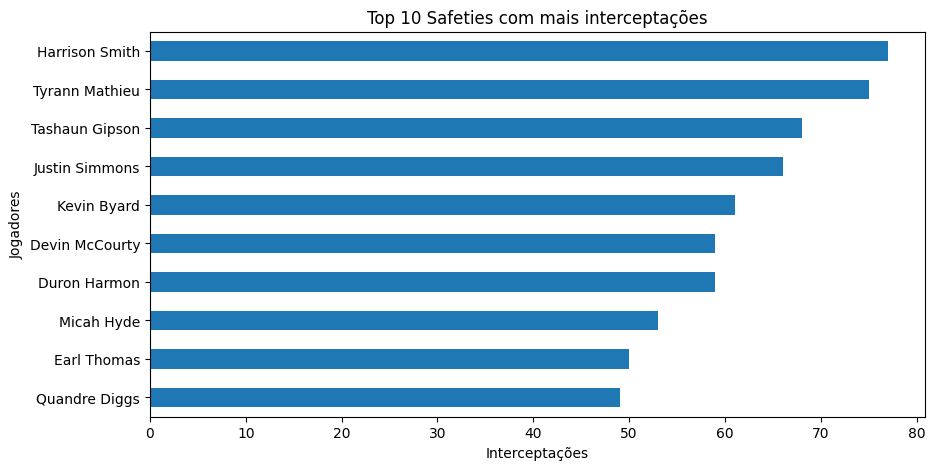

In [524]:
# Top Safeties com mais interceptações
top_safeties_int = safeties.groupby('player_name')['interception'].sum().nlargest(10)
top_safeties_int.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Safeties com mais interceptações')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

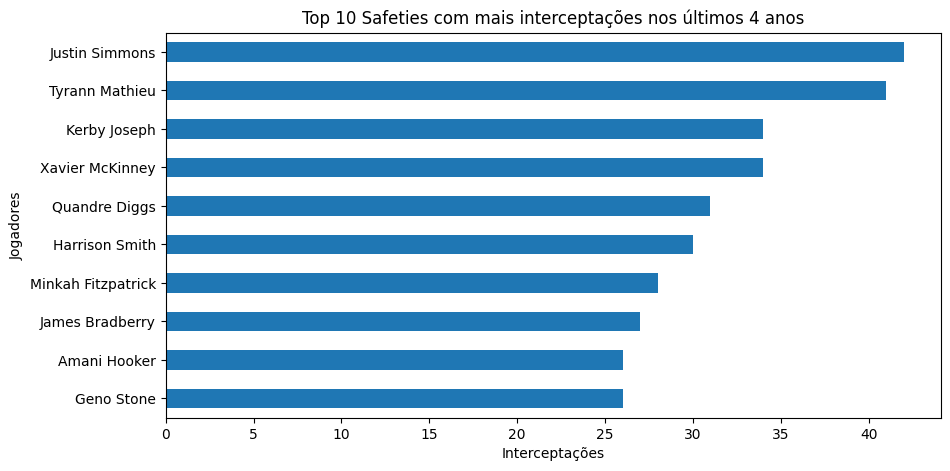

In [525]:
# Top Safeties com mais interceptações nos últimos 4 anos
top_safeties_int_recentes = safeties_recentes.groupby('player_name')['interception'].sum().nlargest(10)
top_safeties_int_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Safeties com mais interceptações nos últimos 4 anos')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

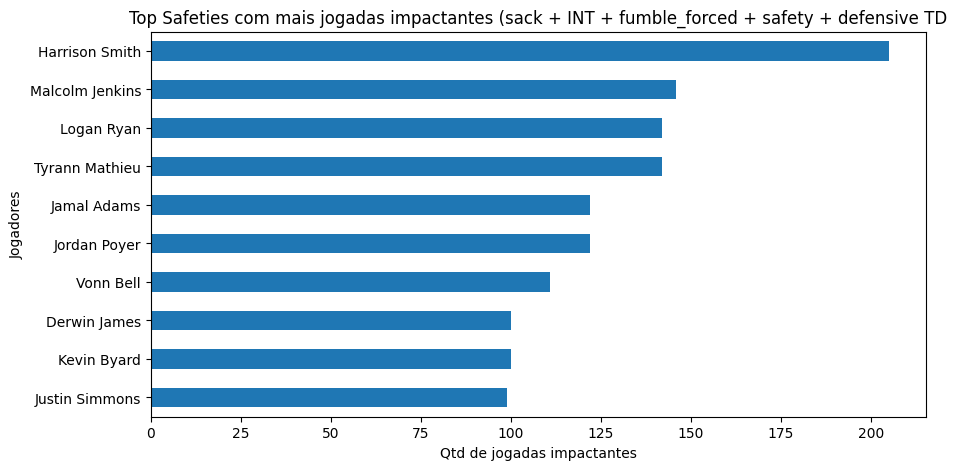

In [526]:
# Top safeties com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD)
top_safeties_impact = safeties.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_safeties_impact.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Safeties com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

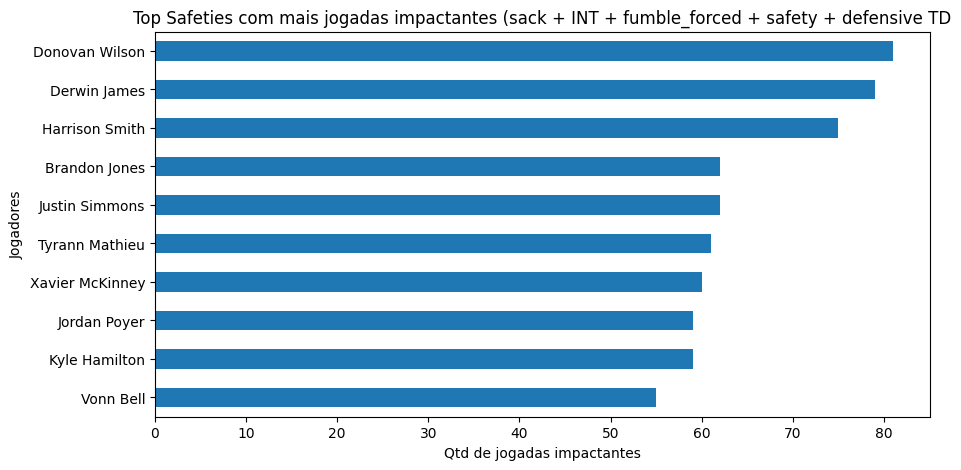

In [527]:
# Top Safeties com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD) nos últimos 4 anos
top_safeties_impact_recente = safeties_recentes.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_safeties_impact_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Safeties com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

####**Linebackers (ILB, OLB, MLB, LB)**

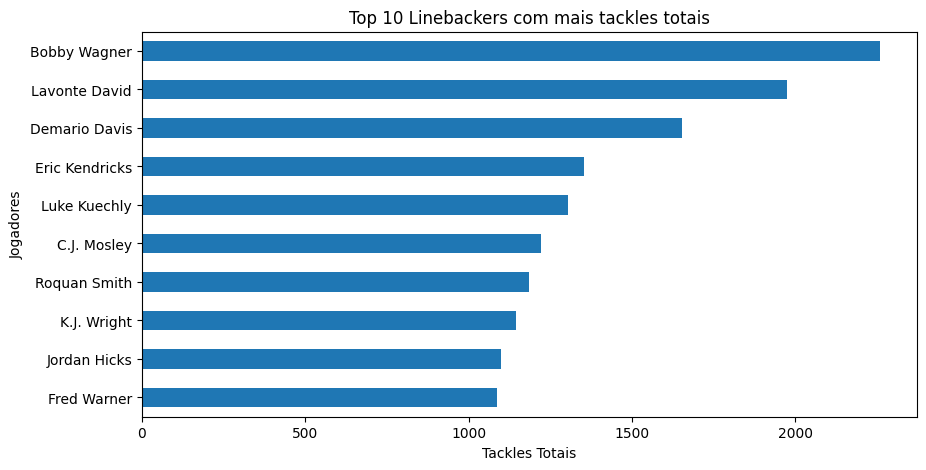

In [528]:
# Top Linebackers com mais tackles totais
lbs = df_defesa_limpo[(df_defesa_limpo['position'] == 'ILB') | (df_defesa_limpo['position'] == 'OLB') | (df_defesa_limpo['position'] == 'MLB') |
                      (df_defesa_limpo['position'] == 'LB')]
top_lbs_tackles = lbs.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_lbs_tackles.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Linebackers com mais tackles totais')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

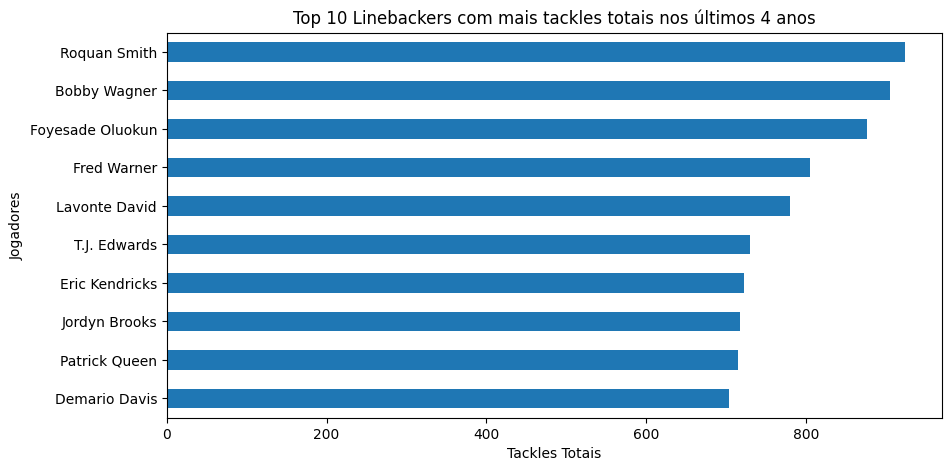

In [529]:
# Top Linebackers com mais tackles totais nos últimos 4 anos
lbs_recentes = df_defesa_limpo[((df_defesa_limpo['position'] == 'ILB') | (df_defesa_limpo['position'] == 'OLB') | (df_defesa_limpo['position'] == 'MLB') |
                      (df_defesa_limpo['position'] == 'LB'))
& (df_defesa_limpo['season'] >= 2020)]
top_lbs_tackles_recente = lbs_recentes.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_lbs_tackles_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Linebackers com mais tackles totais nos últimos 4 anos')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

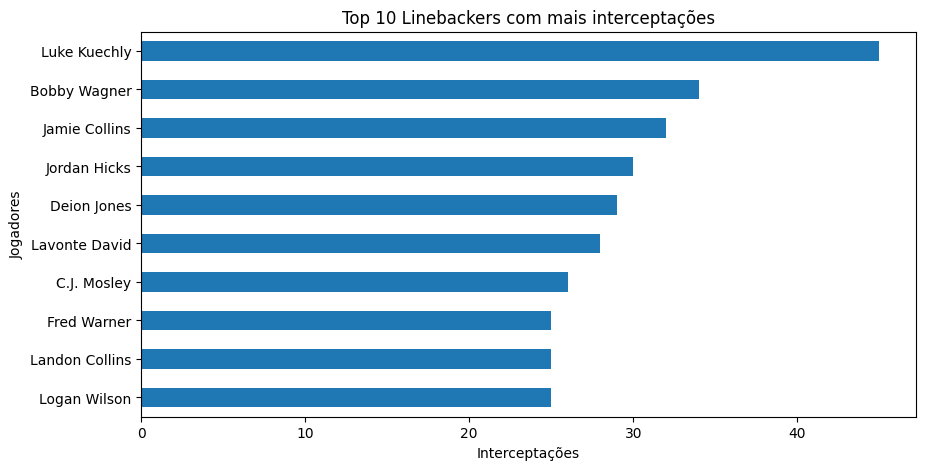

In [530]:
# Top Linebackers com mais interceptações
top_lbs_int = lbs.groupby('player_name')['interception'].sum().nlargest(10)
top_lbs_int.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Linebackers com mais interceptações')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

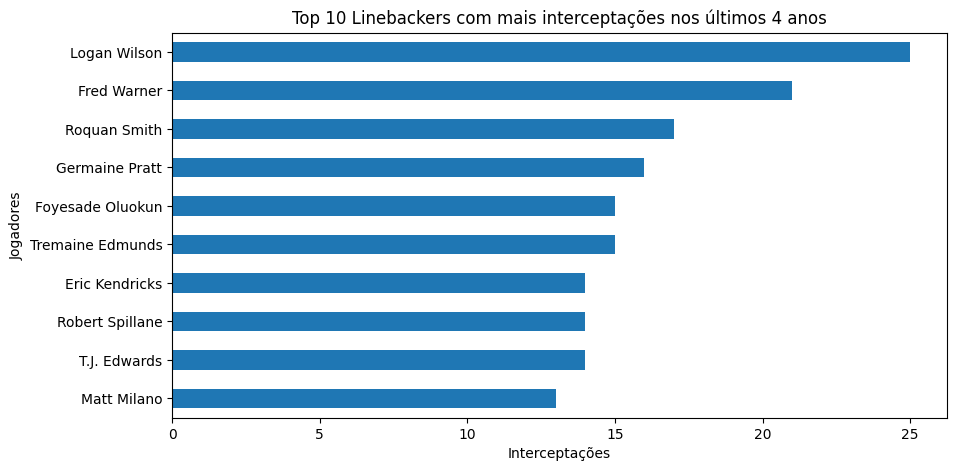

In [531]:
# Top Linebackers com mais interceptações nos últimos 4 anos
top_lbs_int_recentes = lbs_recentes.groupby('player_name')['interception'].sum().nlargest(10)
top_lbs_int_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Linebackers com mais interceptações nos últimos 4 anos')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

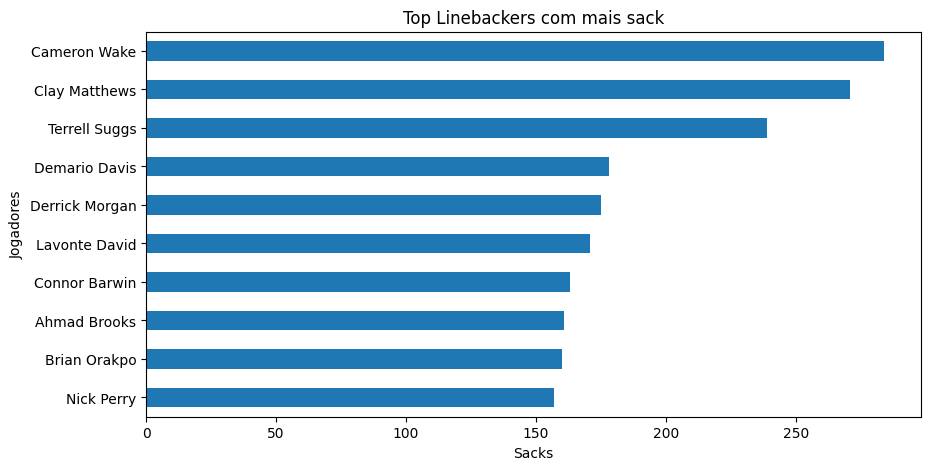

In [532]:
# Top Linebackers com mais sacks
top_lbs_sack = lbs.groupby('player_name')['sack'].sum().nlargest(10)
top_lbs_sack.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Linebackers com mais sack')
plt.xlabel('Sacks')
plt.ylabel('Jogadores')
plt.show()

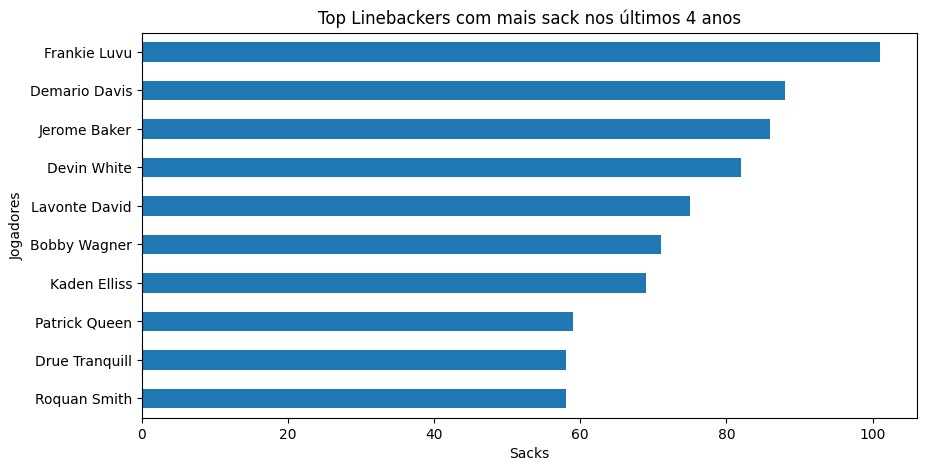

In [533]:
# Top Linebackers com mais sacks nos últimos 4 anos
top_lbs_sack_recente = lbs_recentes.groupby('player_name')['sack'].sum().nlargest(10)
top_lbs_sack_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Linebackers com mais sack nos últimos 4 anos')
plt.xlabel('Sacks')
plt.ylabel('Jogadores')
plt.show()

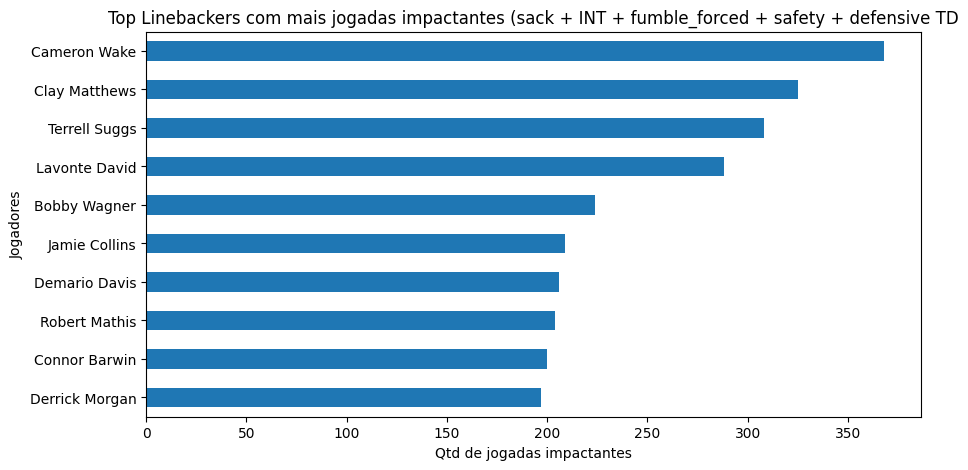

In [534]:
# Top Linebackers com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD)
top_lbs_impact = lbs.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_lbs_impact.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Linebackers com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

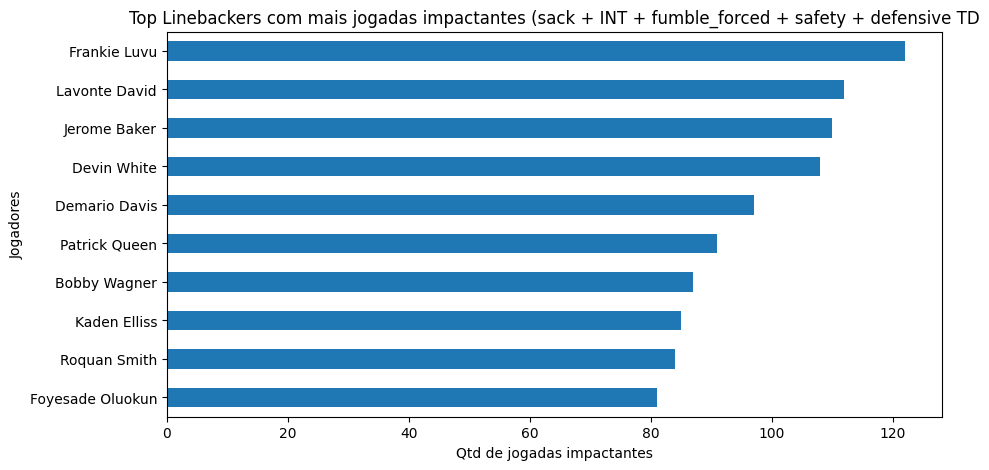

In [535]:
# Top Linebackers com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD) nos últimos 4 anos
top_lbs_impact_recente = lbs_recentes.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_lbs_impact_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Linebackers com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

####**Defensives Lineman (DE, NT, DT e T)**

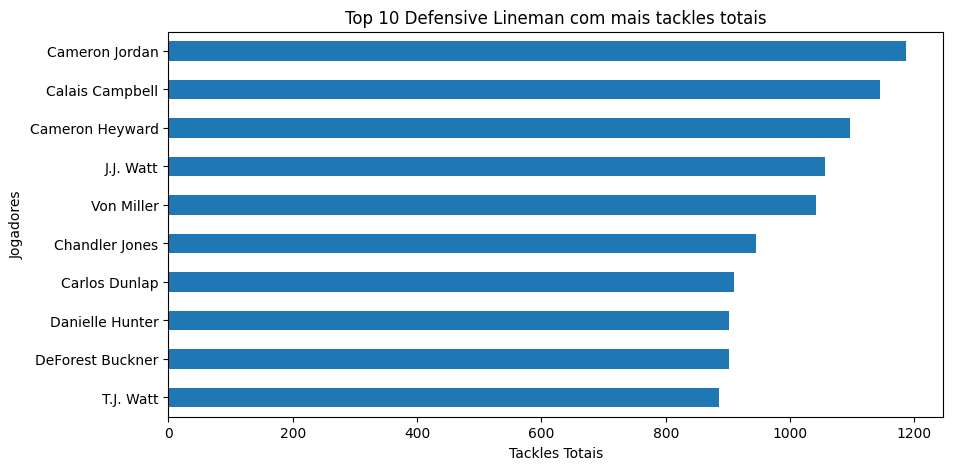

In [536]:
# Top Defensives Lineman com mais tackles totais
dl = df_defesa_limpo[(df_defesa_limpo['position'] == 'DE') | (df_defesa_limpo['position'] == 'NT') | (df_defesa_limpo['position'] == 'DT') |
                      (df_defesa_limpo['position'] == 'T')]
top_dl_tackles = dl.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_dl_tackles.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Defensive Lineman com mais tackles totais')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

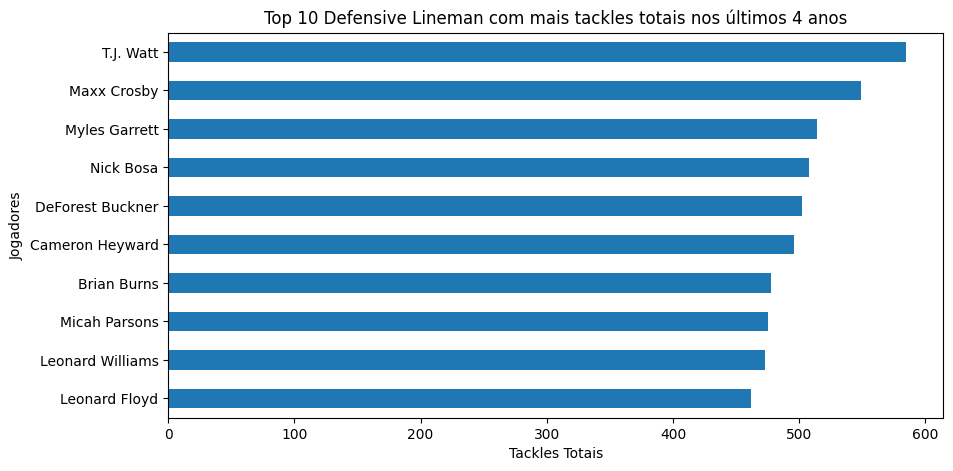

In [537]:
# Top Defensives Lineman com mais tackles totais nos últimos 4 anos
dl_recentes = df_defesa_limpo[((df_defesa_limpo['position'] == 'DE') | (df_defesa_limpo['position'] == 'NT') | (df_defesa_limpo['position'] == 'DT') |
                      (df_defesa_limpo['position'] == 'T'))
& (df_defesa_limpo['season'] >= 2020)]
top_dl_tackles_recente = dl_recentes.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_dl_tackles_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Defensive Lineman com mais tackles totais nos últimos 4 anos')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

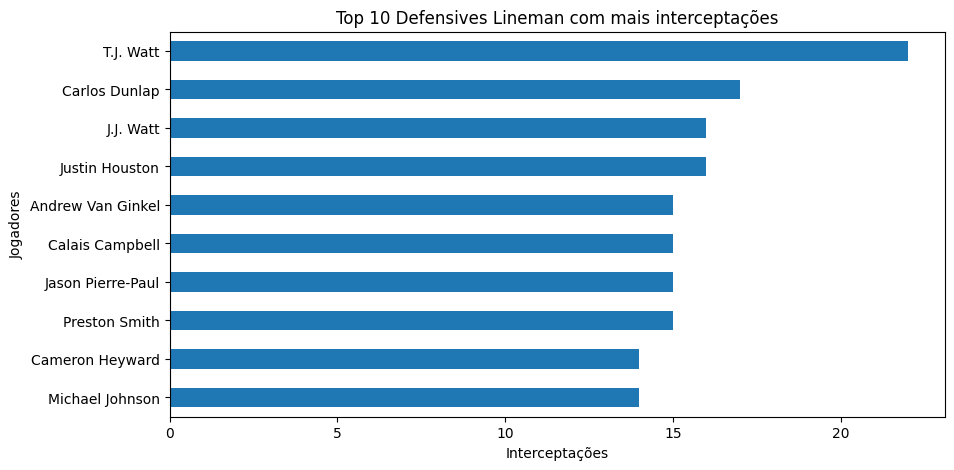

In [538]:
# Top Defensives Lineman com mais interceptações
top_dl_int = dl.groupby('player_name')['interception'].sum().nlargest(10)
top_dl_int.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 Defensives Lineman com mais interceptações')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

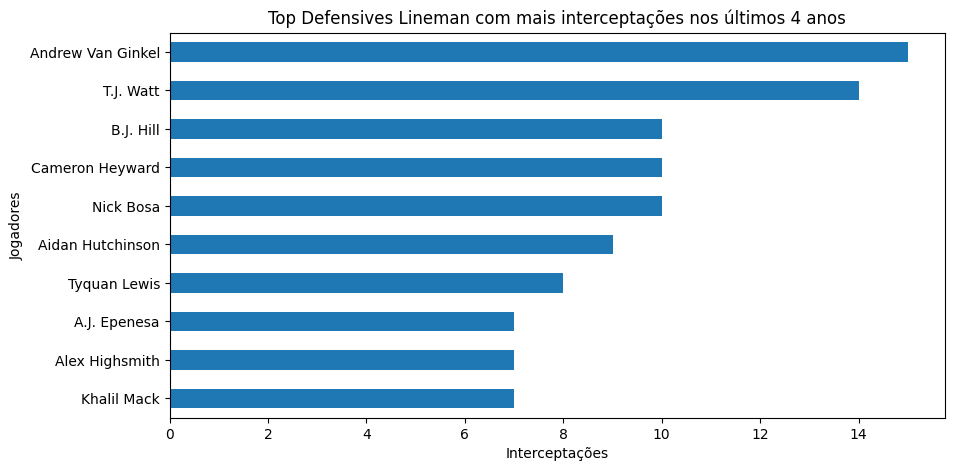

In [539]:
# Top Defensives Lineman com mais interceptações nos últimos 4 anos
top_dl_int_recentes = dl_recentes.groupby('player_name')['interception'].sum().nlargest(10)
top_dl_int_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Defensives Lineman com mais interceptações nos últimos 4 anos')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

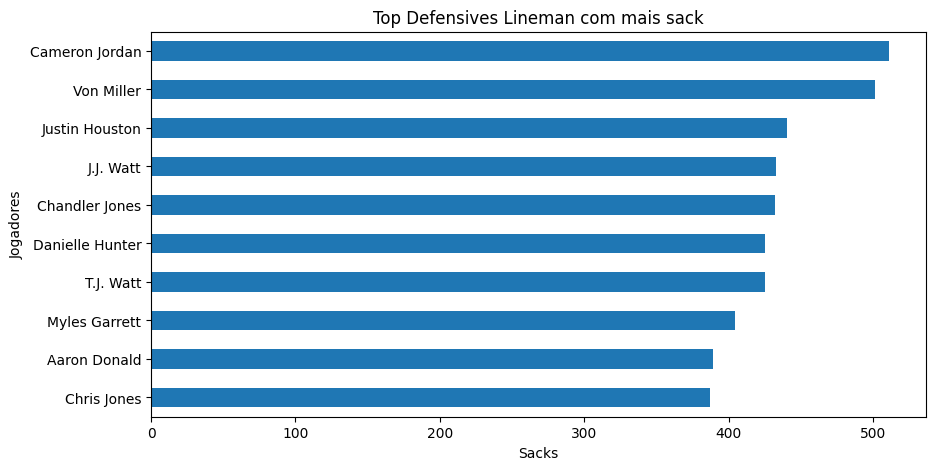

In [540]:
# Top Defensives Lineman com mais sacks
top_dl_sack = dl.groupby('player_name')['sack'].sum().nlargest(10)
top_dl_sack.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Defensives Lineman com mais sack')
plt.xlabel('Sacks')
plt.ylabel('Jogadores')
plt.show()

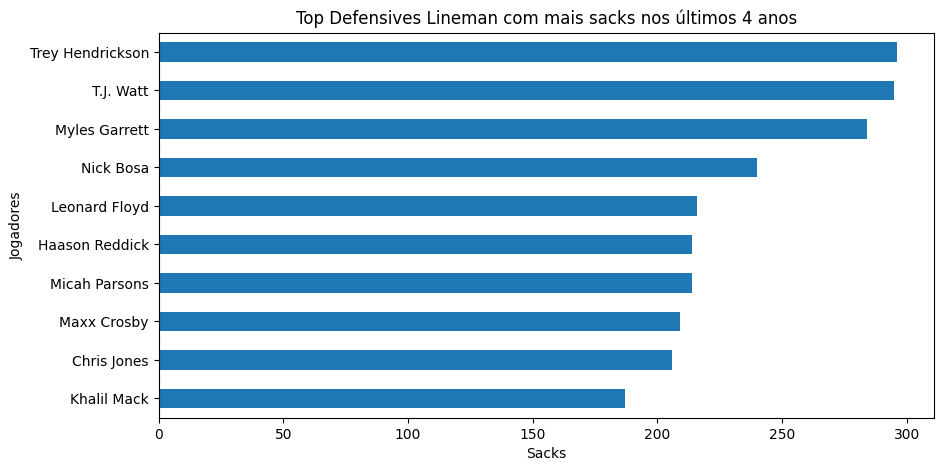

In [541]:
# Top Defensives Lineman com mais sacks nos últimos 4 anos
top_dl_sack_recente = dl_recentes.groupby('player_name')['sack'].sum().nlargest(10)
top_dl_sack_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Defensives Lineman com mais sacks nos últimos 4 anos')
plt.xlabel('Sacks')
plt.ylabel('Jogadores')
plt.show()

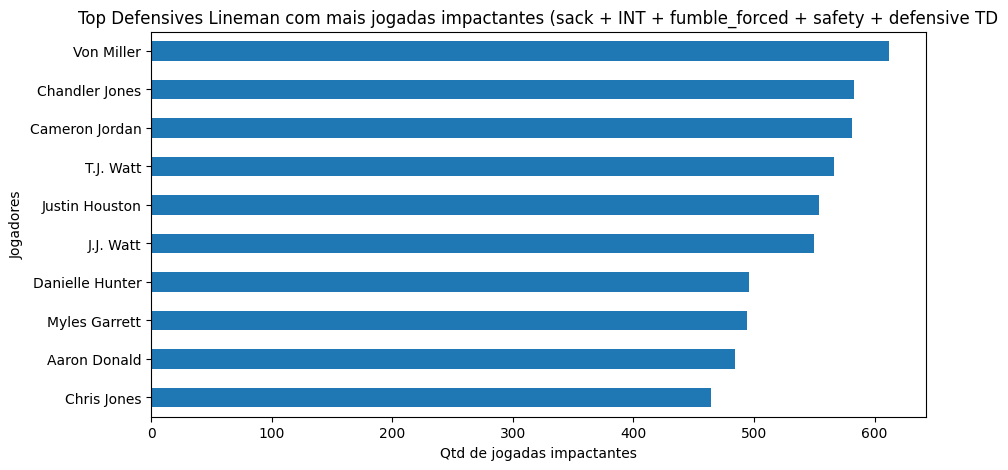

In [542]:
# Top Defensives Lineman com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD)
top_dl_impact = dl.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_dl_impact.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Defensives Lineman com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

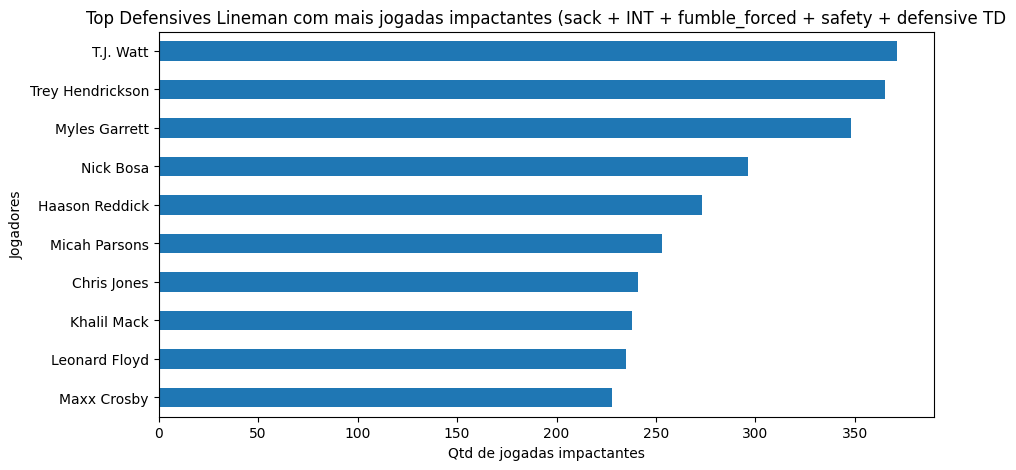

In [543]:
# Top Defensives Lineman com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD) nos últimos 4 anos
top_dl_impact_recente = dl_recentes.groupby('player_name')['impact_plays'].sum().nlargest(10)
top_dl_impact_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top Defensives Lineman com mais jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD')
plt.xlabel('Qtd de jogadas impactantes')
plt.ylabel('Jogadores')
plt.show()

Tackles por jogo: 2012 → 2024
Tackles por jogo na primeira temporada: 2790
Tackles por jogo na última temporada: 3512
Variação percentual entre primeira e última: 25.9%


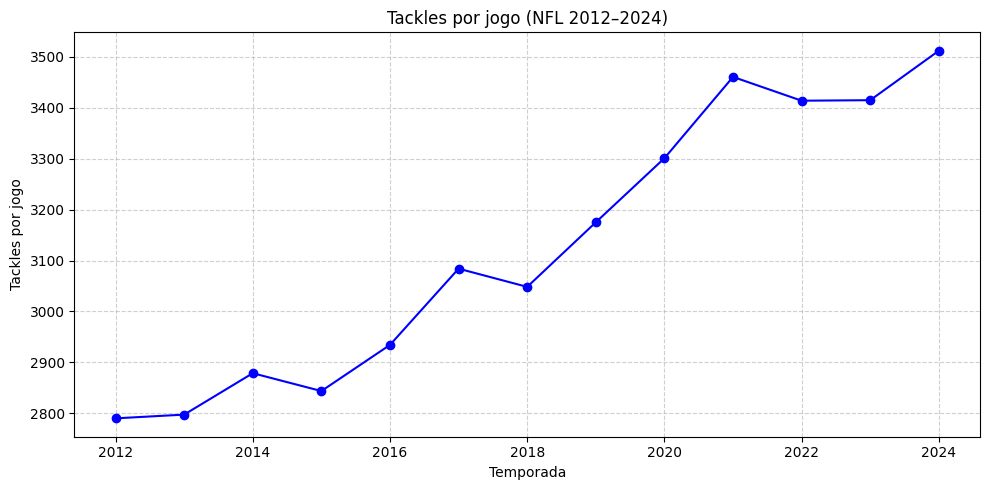

In [554]:
# Agrupando tackles por jogo por temporada
tackle_per_game_por_temporada = (
    df_defesa_limpo
    .groupby('season')['tackles_per_game']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = tackle_per_game_por_temporada['tackles_per_game'].iloc[0], tackle_per_game_por_temporada['tackles_per_game'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Tackles por jogo: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Tackles por jogo na primeira temporada: {primeira:.0f}")
print(f"Tackles por jogo na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(tackle_per_game_por_temporada['season'], tackle_per_game_por_temporada['tackles_per_game'], marker='o', color='blue')
plt.title('Tackles por jogo (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Tackles por jogo')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Sack: 2012 → 2024
Sack na primeira temporada: 4317.00
Sacks na última temporada: 5421.00
Variação percentual entre primeira e última: 25.6%


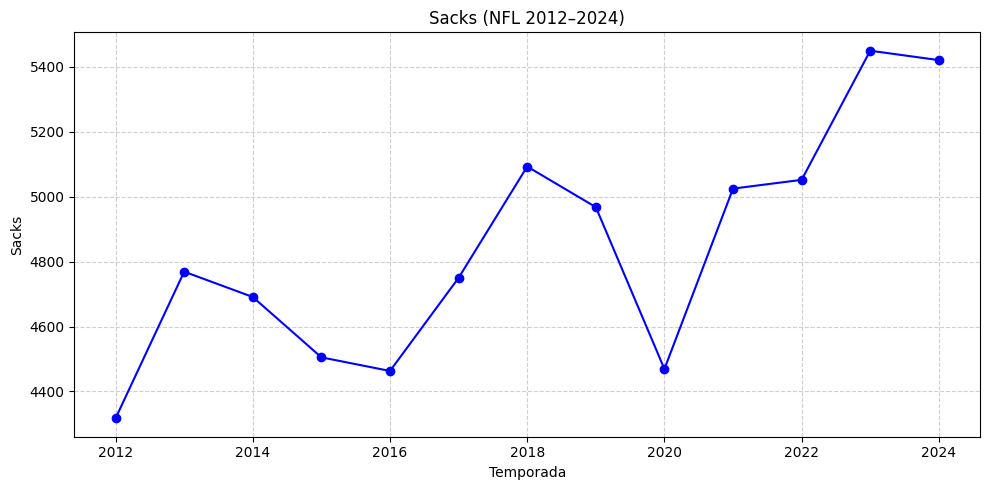

In [562]:
# Agrupando Sacks por temporada
sack_por_temporada = (
    df_defesa_limpo
    .groupby('season')['sack']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = sack_por_temporada['sack'].iloc[0], sack_por_temporada['sack'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Sack: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Sack na primeira temporada: {primeira:.2f}")
print(f"Sacks na última temporada: {ultima:.2f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(sack_por_temporada['season'], sack_por_temporada['sack'], marker='o', color='blue')
plt.title('Sacks (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Sacks')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

QB HIT: 2012 → 2024
QB HIT na primeira temporada: 6018.00
QB HIT na última temporada: 7845.00
Variação percentual entre primeira e última: 30.4%


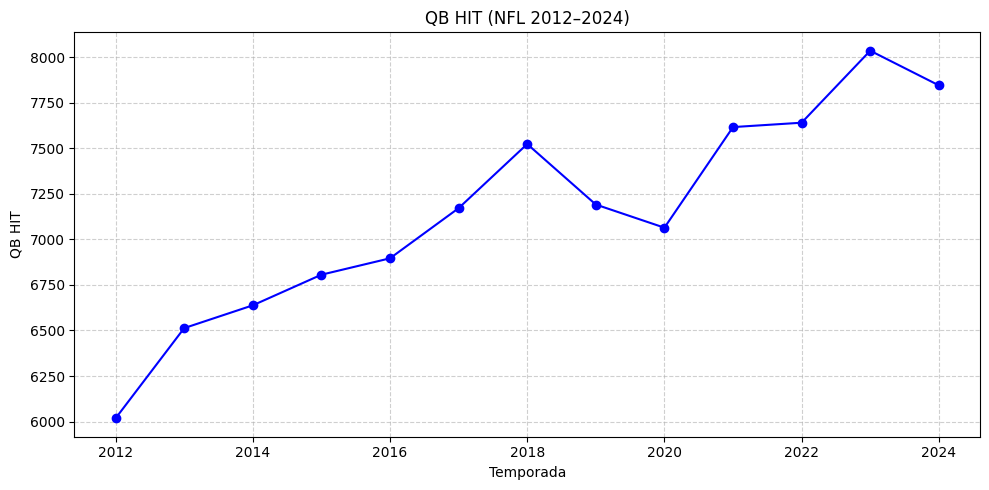

In [563]:
# Agrupando QB hit por temporada
qb_hit_por_temporada = (
    df_defesa_limpo
    .groupby('season')['qb_hit']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = qb_hit_por_temporada['qb_hit'].iloc[0], qb_hit_por_temporada['qb_hit'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"QB HIT: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"QB HIT na primeira temporada: {primeira:.2f}")
print(f"QB HIT na última temporada: {ultima:.2f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(qb_hit_por_temporada['season'], qb_hit_por_temporada['qb_hit'], marker='o', color='blue')
plt.title('QB HIT (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('QB HIT')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Jogadas Impactantes: 2012 → 2024
Jogadas Impactantes na primeira temporada: 6685.00
Jogadas Impactantes na última temporada: 7792.00
Variação percentual entre primeira e última: 16.6%


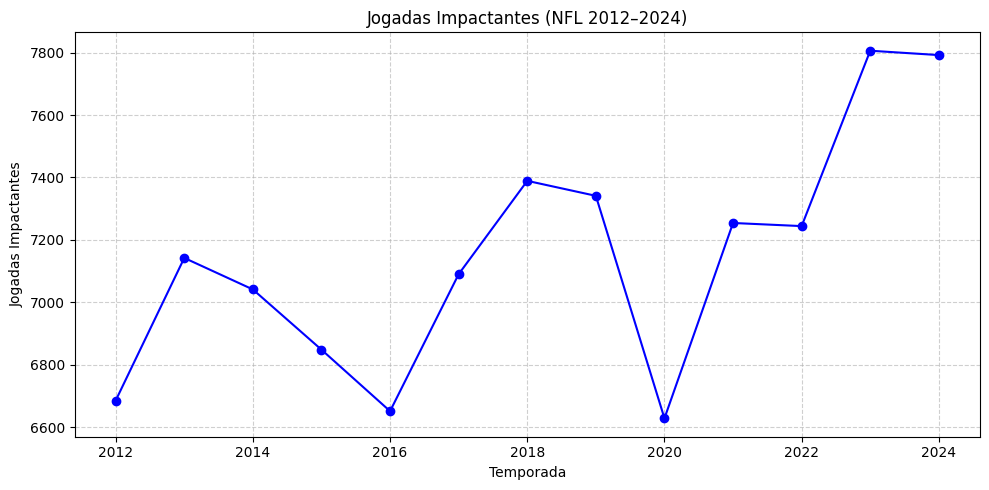

In [566]:
# Agrupando Jogadas Impactantes por temporada
impact_por_temporada = (
    df_defesa_limpo
    .groupby('season')['impact_plays']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = impact_por_temporada['impact_plays'].iloc[0], impact_por_temporada['impact_plays'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Jogadas Impactantes: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Jogadas Impactantes na primeira temporada: {primeira:.2f}")
print(f"Jogadas Impactantes na última temporada: {ultima:.2f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(impact_por_temporada['season'], impact_por_temporada['impact_plays'], marker='o', color='blue')
plt.title('Jogadas Impactantes (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Jogadas Impactantes')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

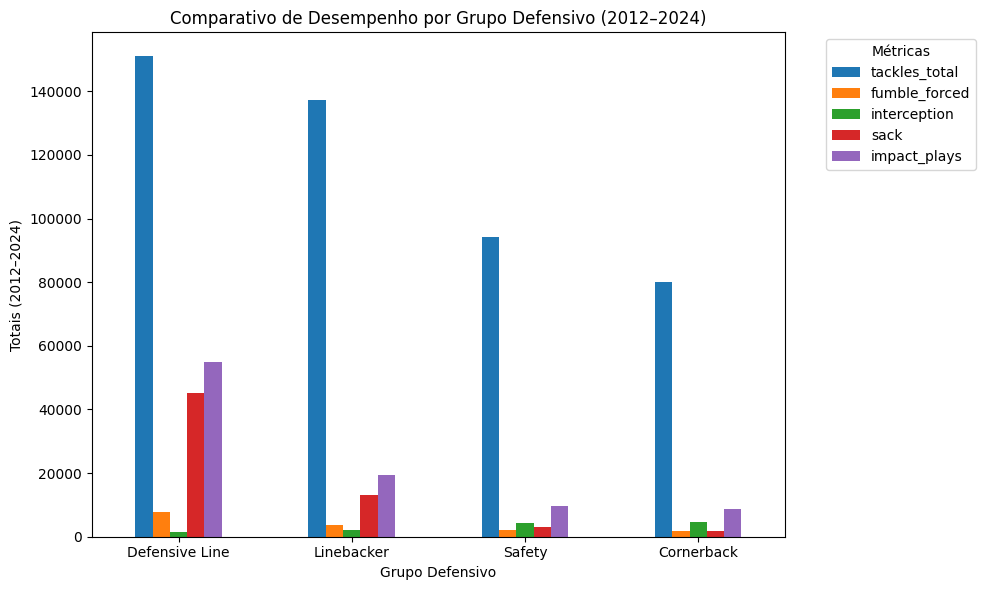

In [572]:
df_defesa_agrupada = df_defesa_limpo.copy()

# Dicionário para agrupar posições semelhantes
map_posicoes = {
    'FS': 'Safety', 'SS': 'Safety', 'S': 'Safety',
    'CB': 'Cornerback', 'DB': 'Cornerback',
    'ILB': 'Linebacker', 'OLB': 'Linebacker', 'MLB': 'Linebacker', 'LB': 'Linebacker',
    'DE': 'Defensive Line', 'NT': 'Defensive Line', 'DT': 'Defensive Line', 'T': 'Defensive Line'
}

# Criar uma nova coluna com o grupo de posição
df_defesa_agrupada['pos_agrupada'] = df_defesa_agrupada['position'].map(map_posicoes)

# Remover linhas com posições não defensivas (sem grupo)
df_defesa_grupos = df_defesa_agrupada.dropna(subset=['pos_agrupada'])

# Agrupar por grupo de posição e somar métricas relevantes
pos_agrupada_status = (
    df_defesa_grupos
    .groupby('pos_agrupada')[['tackles_total', 'fumble_forced', 'interception', 'sack', 'impact_plays']]
    .sum()
    .sort_values('impact_plays', ascending=False)
)

# Plotar gráfico
pos_agrupada_status.plot(
    kind='bar',
    figsize=(10,6),
    title='Comparativo de Desempenho por Grupo Defensivo (2012–2024)',
    rot=0
)

plt.xlabel('Grupo Defensivo')
plt.ylabel('Totais (2012–2024)')
plt.legend(title='Métricas', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

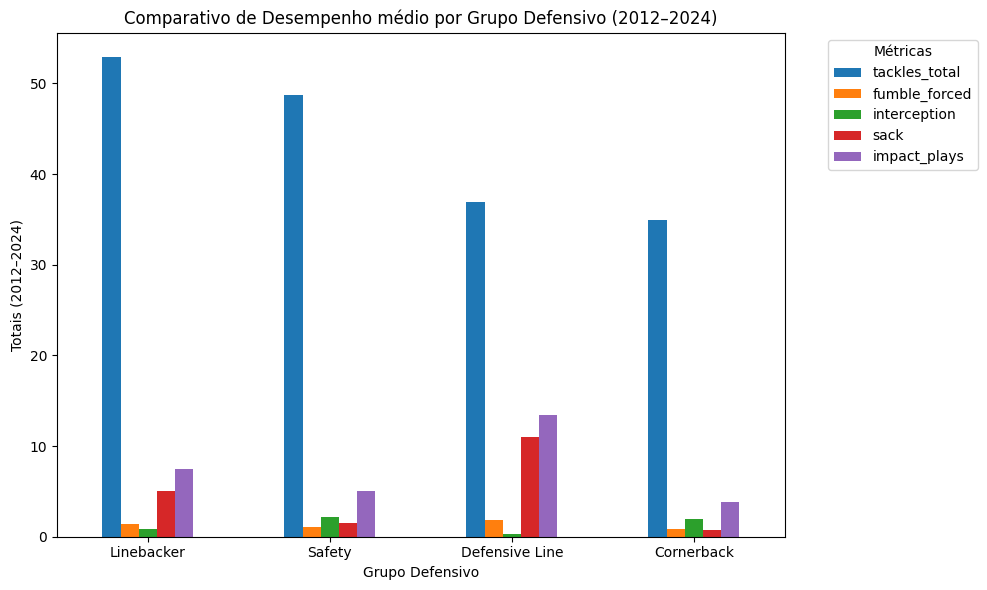

In [573]:
df_defesa_agrupada = df_defesa_limpo.copy()

# Dicionário para agrupar posições semelhantes
map_posicoes = {
    'FS': 'Safety', 'SS': 'Safety', 'S': 'Safety',
    'CB': 'Cornerback', 'DB': 'Cornerback',
    'ILB': 'Linebacker', 'OLB': 'Linebacker', 'MLB': 'Linebacker', 'LB': 'Linebacker',
    'DE': 'Defensive Line', 'NT': 'Defensive Line', 'DT': 'Defensive Line', 'T': 'Defensive Line'
}

# Criar uma nova coluna com o grupo de posição
df_defesa_agrupada['pos_agrupada'] = df_defesa_agrupada['position'].map(map_posicoes)

# Remover linhas com posições não defensivas (sem grupo)
df_defesa_grupos = df_defesa_agrupada.dropna(subset=['pos_agrupada'])

# Agrupar por grupo de posição e somar métricas relevantes
pos_agrupada_status = (
    df_defesa_grupos
    .groupby('pos_agrupada')[['tackles_total', 'fumble_forced', 'interception', 'sack', 'impact_plays']]
    .mean()
    .sort_values('tackles_total', ascending=False)
)

# Plotar gráfico
pos_agrupada_status.plot(
    kind='bar',
    figsize=(10,6),
    title='Comparativo de Desempenho médio por Grupo Defensivo (2012–2024)',
    rot=0
)

plt.xlabel('Grupo Defensivo')
plt.ylabel('Totais (2012–2024)')
plt.legend(title='Métricas', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()